# 事前准备

In [5]:
#import
import json
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import alphalens
import os
import statsmodels.api as sm
import math
import scipy.stats as st
import time
import datetime

import backtrader as bt
from backtrader.feeds import PandasData

In [2]:
##############################数据清洗函数###########################
class clean():
    '''数据清洗函数'''
    def __init__(self):
        pass

    #绝对差中位数法
    def filter_MAD(self, series, n=3):
        med = series.median()
        mad = abs(series - med).median()
        limit_up = med + (n * 1.4826 * mad)
        limit_down = med - (n * 1.4826 * mad)
        return np.clip(series, limit_down, limit_up)

    # 三倍标准差法去极值
    def filter_extreme_by_sigma(self, series, n=3):
        # 计算均值
        mean = series.mean()
        # 计算方差
        std = series.std()
        #计算上下限的值
        max_value = mean + n * std
        min_value = mean - n * std
        return np.clip(series, min_value, max_value)

    #标准化
    def standardize(self, series):
        mean = series.mean()
        std = series.std()
        return (series - mean) / std

#     #求残差
#     def OlsResid(self, y, x):
#         df = pd.concat([y, x], axis=1)
#         if df.dropna().shape[0] > 0:
#             resid = sm.OLS(y, x, missing='drop').fit().resid
#             return resid.reindex(df.index)
#         else:
#             return y

#     #中性化，已失败
#     def neutralization(self, df, MV_name=None, Idu_name=None):
#         '''
#         df是因子和市值（如有）、行业（如有）组成的dataframe，
#         MV_name和Idu_name分别是市值和行业所在列的名字，
#         MV_name只能是str，Idu_name是str或者list
#         '''
#         MarketValue = None
#         Industry = None
#         if type(Idu_name) == str:  #行业只有一列
#             Industry = df[Idu_name]
#             industry_dummy = pd.get_dummies(Industry)
#         elif type(Idu_name) == list:  #行业有多列（已经分成哑变量）
#             Industry = df[Idu_name]
#             industry_dummy = Industry
#         if type(MV_name) == str:
#             MarketValue = df[MV_name]
#             lnMV = np.log(MarketValue)
#         #组成自变量
#         if MV_name != None and Idu_name != None:
#             x = pd.concat([lnMV, industry_dummy], axis=1)
#             df = df.drop([MV_name, Idu_name],axis=1)
#         elif MV_name != None:
#             x = lnMV
#             x = sm.add_constant(x)
#             df = df.drop([MV_name],axis=1)
#         elif Idu_name != None:
#             x = industry_dummy
#             df = df.drop([Idu_name],axis=1)
#         resid = df.apply(func=class_clean.OlsResid, args=(x, ), axis=0)
#         result = pd.concat([resid, MarketValue, Industry],axis=1)
#         return result

#中性化

    def neutralization(self, series, MarketValue=None, Industry=None):
        if type(Industry) == pd.Series:
            industry_dummy = pd.get_dummies(Industry)
        elif type(Industry) == pd.DataFrame:
            industry_dummy = Industry
        if type(MarketValue) == pd.Series:
            lnMV = np.log(MarketValue)
        y = series
        if not MarketValue is None:
            if not Industry is None:
                x = pd.concat([lnMV, industry_dummy], axis=1)
            else:
                x = lnMV
                x = sm.add_constant(x)
        elif not Industry is None:
            x = industry_dummy
        result = sm.OLS(y, x).fit()
        return result.resid

In [3]:
##############################IC指标计算#############################
#RankIC计算
def IC_rank(factor, close, period=5):
    '''
    根据因子值和股价，算出每隔一个period的rank IC。
    factor和close是有MultiIndex的Series，时间在索引级别0，投资标的在索引级别1
    '''
    tradedates = factor.index.get_level_values(0).unique()
    ic_df = pd.DataFrame(columns=["IC", "p-value"])
    for i in range(0, len(tradedates) - period, period):
#     for i in range(0, len(tradedates) - period):
        #因子在T0的值
        time_factor = tradedates[i]
        #收市价T1期区间的起点；收益率的T1期间的起点是i+1
        time_return_start = tradedates[i]
        #收市价T1期区间的终点，共有period+1天
        time_return_end = tradedates[i + period]
        #取出因子数据
        df_factor_data = factor[time_factor]
        #取出收市价并计算收益率
        df_return_data = close[time_return_end] / close[time_return_start] - 1
        #合并
        df_combine = pd.concat([df_factor_data, df_return_data],
                               axis=1).dropna(axis=0)
        df_combine.columns = ["factor", "returns"]
        #排序
        df_combine = df_combine.rank()
        #计算相关系数
        ic, p_value = st.pearsonr(df_combine['factor'], df_combine['returns'])
        #每一轮计算得到的IC值时，都是该时点之前最近一期的收益率和上一期因子值的相关系数,写入DataFrame
        ic_df.loc[time_return_start, "IC"] = ic
        ic_df.loc[time_return_start, "p-value"] = p_value
    return ic_df


#计算所有因子的IC值
def IC_rank_all(factors, close, periods=[5]):
    '''
    Params:
    factors: 因子的dataframe，index是多层索引['Date','stockcode']，列是不同的因子
    close: 价格的series
    periods: 计算的期间长，是一个series
    
    '''
    IC_df_all = pd.DataFrame()
    for period in periods:
        IC_df = pd.DataFrame()
        for f in factors.columns:
            IC_series = IC_rank(factors[f], close, period=period).iloc[:, 0]
            IC_series.name = f
            IC_df = pd.concat([IC_df, IC_series], axis=1)
        IC_df.insert(0, "period", str(period) + "D")
        IC_df_all = pd.concat([IC_df_all, IC_df])
    IC_df_all.index.name = "Date"
    IC_df_all = IC_df_all.reset_index().set_index(["period", "Date"])
    return IC_df_all


#IC画图
def plot_IC(IC, Name, period):
    '''
    根据IC_rank函数计算出来结果画图
    Params:
    Name: 因子名字
    period: 调仓频率
    '''
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    y = IC.iloc[:, 0]
    fig = plt.figure(figsize=(16, 8))
    ax = plt.axes()
    #     xtick = np.arange(0,len(IC),600)
    #     xticklabel = pd.Series(IC.index[xtick])
    plt.bar(IC.index, y, color='darkred',label=Name)
    ax.legend(loc='upper left', bbox_to_anchor=(0.85, 0.97))
    ax1 = plt.twinx()
    ax1.plot(IC.index, y.cumsum(), color='orange',label="Cumulative")
    ax1.legend(loc='upper left', bbox_to_anchor=(0.85, 0.93))
#     y.cumsum().plot(color='orange')
    ax.set_xticks(pd.date_range(IC.index[0], IC.index[-1], freq="1Y"))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    #     ax.set_xticklabels(xticklabel)
    plt.title(Name + "  {}天调仓频率，IC = {}, ICIR = {}".format(period,round(y.mean(), 4),
                                                 round(y.mean() / y.std(), 4)))

In [42]:
###############################分组回测##############################
#分组回测计算表格
def Grouptest_Factors(factors, Price, period=5, groups=5):
    '''
    factors是带有multiIndex的DataFrame，
    Price是带有multiIndex的Series，
    period是调仓区间，
    groups是分组数量
    '''
    #计算个股每天收益
    ret = (Price.unstack() / Price.unstack().shift(1)) - 1
    #用来存放收益结果
    group_returns = pd.DataFrame()
    #获得时间索引
    tradedates = factors.index.get_level_values(0).unique()
    #轮流对因子进行计算
    for f in factors.columns:
        #用来单独每个因子存放收益
        group_returns_1factor = pd.DataFrame()
        #每隔period天做循环，重新排序
        for i in range(0, len(tradedates) - period, period):
            #提取数据
            df = factors.loc[tradedates[i], f].copy()
            #排序
            df.sort_values(inplace=True, ascending=True)
            #计算列表长度（股票数量）
            lens = len(df)
            #划定组别
            df = pd.concat([df, np.ceil(df.rank() / (lens / groups))], axis=1)
            df.columns = [f, "groups"]
            #计算未来period天的日期，此period天要计算收益
            dates = tradedates[range(i + 1, i + 1 + period)]
            #获取未来period天的收益，变成行索引是号码，列索引是日期
            df_returns = ret.loc[dates].T.copy()
            #合并，groups成为新一列
            df_returns = pd.concat([df_returns, df["groups"]], axis=1)
            #根据组别分组计算平均收益，转置成日期作为行索引，组别是列索引
            df_returns = df_returns.groupby("groups").mean().T.sort_index()
            df_returns.columns = ["group " + str(i + 1) for i in range(groups)]
            df_returns.index.name = "Date"
            #插入新列，表示因子名称
            df_returns.insert(0, "factor", f)
            #将各个组每天收益写入group_returns_1factor
            group_returns_1factor = pd.concat(
                [group_returns_1factor, df_returns])
        #所有日期计算完后，计算多空组合
        if group_returns_1factor["group " + str(1)].mean(
        ) > group_returns_1factor["group " + str(groups)].mean():
            group_returns_1factor["group L-S"] = group_returns_1factor[
                "group " + str(1)] - group_returns_1factor["group " +
                                                           str(groups)]
        else:
            group_returns_1factor["group L-S"] = group_returns_1factor[
                "group " + str(groups)] - group_returns_1factor["group " +
                                                                str(1)]
        #将group_returns_1factor并入group_returns
        group_returns = pd.concat([group_returns, group_returns_1factor])

    #设定行索引
    group_returns = group_returns.pivot_table(index=["factor", "Date"],
                                              sort=False)
    return group_returns


#计算累计收益
def cum_returns(group_returns):
    '''根据Grouptest_Factors制作出来的收益率表格计算累计收益表格'''
    df_bactest = group_returns.groupby("factor").apply(lambda x:
                                                       (x + 1).cumprod())
    return df_bactest


#分组回测画图
def plot_groups(df_bactest):
    '''根据cum_returns计算出来的累计收益表格画图'''
    #正确显示中文
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    #提取因子的名字列表以及其长度
    factor_names = df_bactest.index.get_level_values(0).unique()
    n = len(factor_names)
    i = 0
    #制作画布以及分区画画
    fig, axes = plt.subplots(math.ceil(n / 2),
                             2,
                             sharex=True,
                             sharey=True,
                             figsize=(24, 7 * math.ceil(n / 2)))
    for factor_name in factor_names:
#         factor_name = factor_names[i]
        df_bactest.loc[factor_name].plot(ax=axes[i // 2, i % 2],
                                         title="因子分组回测：" + factor_name)
        i += 1

In [5]:
###############################因子合成回测##############################
#调整因子值
def adjust_factors(factors, direction):
    '''direction是长度跟factors列数相同的列表，且值只能是-1和1，例如[-1,1,-1,1,-1,1,-1,1]。
    因子值与收益正相关时，设定为1；否则为-1'''
    for n in a:
        if n != -1 and n != 1:
            print(
                "direction是长度跟factors列数相同的列表，且值只能是-1和1，例如[-1,1,-1,1,-1,1,-1,1]。"
            )
            return
    adj = pd.Series(list(direction), index=factors.columns)
    return factors * adj


#因子权重不变的回测
def backtest_unchanged_weight(factors,
                              Price,
                              weight=None,
                              invest_percentage=0.2,
                              period=5,
                              Benchmark=None):
    '''factors的列数必须跟weight的长度相同！！！'''
    #如果没有输入weight，就给予相等权重
    if weight is None:
        weight = pd.Series(1 / factors.shape[1], index=factors.columns)
    elif factors.shape[1] != len(weight):
        return print("ValueError: factors的列数必须跟weight的长度相同！！！")

    #计算个股每天收益
    ret = (Price.unstack() / Price.unstack().shift(1)) - 1
    #用来存放收益结果
    returns = pd.Series(dtype="float64", name="Portfolio Returns")
    #获得时间索引
    tradedates = factors.index.get_level_values(0).unique()
    #每隔period天做循环，重新排序
    for i in range(0, len(tradedates) - period, period):
        #提取数据
        df = factors.loc[tradedates[i]].copy()
        #计算合成后的因子值
        df_scores = (df * weight).sum(axis=1).sort_values(ascending=False)
        #找出前 invest_percentage 的股票
        stock_pool = df_scores[
            df_scores > df_scores.quantile(1 - invest_percentage)].index
        #计算未来period天的日期，此period天要计算收益
        dates = tradedates[range(i + 1, i + 1 + period)]
        #获取股票池未来period天的收益，并计算平均值
        df_returns = ret.loc[dates, stock_pool].mean(axis=1)
        #将每天收益写入group
        returns = pd.concat([returns, df_returns])
    #加入第一天，排序，命名
    returns[tradedates[0]] = 0
    returns.sort_index(inplace=True)
    returns.name = "Result"
    #如果有输入Benchmark，加入Benchmark
    if not Benchmark is None:
        returns = pd.concat([returns, Benchmark.pct_change()], axis=1).dropna()
        #第一天收益设定为0
        returns.iloc[0] = 0
    #计算累计收益
    backtest_cum_result = (returns + 1).cumprod()
    return returns, backtest_cum_result


#组合因子回测画图
def plot_backtest(backtest_cum_result):
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    backtest_cum_result.plot(figsize=(16, 8), title="合成因子表现")

In [6]:
################################评价指标###############################
class Indicators():
    def __init__(self, backtest_result, backtest_cum_result):
        '''
        Params:
        backtest_result：收益，以日期为索引的Series
        backtest_cum_result：累计收益，以日期为索引的Series
        '''
        self.returns = backtest_result.sort_index()
        self.cum_returns = backtest_cum_result.sort_index()
    
    #总收益
    def total_return(self):
        '''
        returns: 
        total_ret: 总收益
        '''
        cum_returns = self.cum_returns
        total_ret = cum_returns.values[-1] / cum_returns.values[0]-1
        return total_ret

    #最大回撤
    def max_down(self):
        '''
        returns:
        max_down_value: 最大回撤比例
        max_down_starttime：最大回撤开始时间
        max_down_endtime： 最大回撤结束时间
        '''
        cum_returns = self.cum_returns
        #计算回撤
        down = (1 - (cum_returns / cum_returns.cummax()))
        #最大值就是最大回撤
        max_down_value = down.sort_values(ascending=False).head(1).values[0]
        #最大回撤时间
        max_down_endtime = down.sort_values(ascending=False).head(1).index[0]
        #回撤开始时间
        max_down_starttime = cum_returns[
            cum_returns.index < max_down_endtime].sort_values(
                ascending=False).head(1).index[0]
        return max_down_value, max_down_starttime, max_down_endtime

    #年化收益率
    def annual_return(self):
        '''
        returns:
        Annual_Ret: 年化收益
        '''
        cum_returns = self.cum_returns
        #计算天数
        trade_time = len(cum_returns.index)
        #计算收益
        Annual_Ret = (cum_returns.values[-1] / cum_returns.values[0])**(250/trade_time)-1
        return Annual_Ret

    #年化波动率
    '''
    returns:
    Volatility: 年化波动率
    '''
    def volatility(self):
        returns = self.returns
        Volatility = returns.iloc[1:].std() * np.sqrt(250)
        return Volatility

    #夏普比率
    def sharpe_ratio(self, rf=0.026):
        '''
        Params:
        rf: 无风险利率
        returns:
        sharpe_ratio: 夏普比率
         '''
        Annual_Ret = self.annual_return()
        Volatility = self.volatility()
        sharpe_ratio = (Annual_Ret - rf) / Volatility
        return sharpe_ratio
    
    #胜率
    def win_rate(self,Benchmark):
        '''
        Params: 
        Benchmark: 基准序列
        returns:
        win: 胜率
        '''
        returns = self.returns
        compare_returns = pd.concat([returns,Benchmark],axis=1).dropna()
        win = (compare_returns.iloc[:,0]>compare_returns.iloc[:,1]).sum()/len(compare_returns)
        return win
    


# 读取并整合数据

In [2]:
#提取数据
start_time = datetime.datetime.now()

Info = pd.read_excel('Information.xlsx')
MktCap = pd.read_excel('MktCap.xlsx', parse_dates=['Date'], index_col=0)
Price = pd.read_excel('Price.xlsx', parse_dates=['Date'], index_col=0)
PE_TTM = pd.read_excel('Value Factors.xlsx',
                       sheet_name='PE_TTM',
                       parse_dates=['Date'],
                       index_col=0)
PS_TTM = pd.read_excel('Value Factors.xlsx',
                       sheet_name='PS_TTM',
                       parse_dates=['Date'],
                       index_col=0)
PB = pd.read_excel('Value Factors.xlsx',
                   sheet_name='PB',
                   parse_dates=['Date'],
                   index_col=0)

end_time = datetime.datetime.now()
print(end_time - start_time)

0:01:17.683992


In [20]:
#计算动量因子
Mom_1D = Price.pct_change(1)
Mom_5D = Price.pct_change(5)
Mom_20D = Price.pct_change(20)
Mom_60D = Price.pct_change(60)
Mom_120D = Price.pct_change(120)
Mom_180D = Price.pct_change(180)
Mom_240D = Price.pct_change(240)

In [37]:
#因子、股价、市值合并
a = [Price, MktCap, Mom_1D, Mom_5D, Mom_20D, Mom_60D, Mom_120D, Mom_180D, Mom_240D, PE_TTM, PS_TTM, PB]
a = [df.stack() for df in a]

df_raw = pd.concat(a,axis=1)

df_raw.columns = ['Price', 'MktCap', 'Mom_1D', 'Mom_5D', 'Mom_20D', 'Mom_60D', 'Mom_120D', 'Mom_180D', 'Mom_240D', 'PE_TTM', 'PS_TTM', 'PB']
df_raw.index.names = ["Date", "stockcode"]

Price        MktCap  Mom_1D    Mom_5D   Mom_20D  \
Date       stockcode                                                         
2010-01-04 0002.HK     32.557379  1.264428e+11     NaN       NaN       NaN   
           0003.HK      5.286003  1.288146e+11     NaN       NaN       NaN   
           0004.HK      7.695268  1.233730e+11     NaN       NaN       NaN   
           0005.HK     48.223380  1.545332e+12     NaN       NaN       NaN   
           0006.HK     18.764886  9.081283e+10     NaN       NaN       NaN   
...                          ...           ...     ...       ...       ...   
2022-05-18 9993.HK      4.350000           NaN     0.0 -0.026846 -0.112245   
           9995.HK     28.350000           NaN     0.0  0.017953 -0.242991   
           9996.HK      6.730000           NaN     0.0  0.201786 -0.079343   
           9997.HK      6.910000           NaN     0.0 -0.015670 -0.044260   
           9999.HK    151.200000           NaN     0.0  0.061053  0.004651   

                       Mom_60D  Mom_120D  Mom_180D  Mom_240D      PE_TTM  \
Date       stockcode                                                       
2010-01-04 0002.HK         NaN       NaN       NaN       NaN   23.709513   
           0003.HK         NaN       NaN       NaN       NaN   26.951490   
           0004.HK         NaN       NaN       NaN       NaN   25.548349   
           0005.HK         NaN       NaN       NaN       NaN  184.285049   
           0006.HK         NaN       NaN       NaN       NaN   12.066547   
...                        ...       ...       ...       ...         ...   
2022-05-18 9993.HK   -0.015837  0.141732  0.013986 -0.039735         NaN   
           9995.HK   -0.478381 -0.732547 -0.701579 -0.737985         NaN   
           9996.HK   -0.451954 -0.645042 -0.717227 -0.763028         NaN   
           9997.HK   -0.187059 -0.202079 -0.271865 -0.504872         NaN   
           9999.HK   -0.036622 -0.143850  0.271974 -0.152270         NaN   

                         PS_TTM        PB  
Date       stockcode                       
2010-01-04 0002.HK     2.569611  1.921244  
           0003.HK    10.661875  4.102835  
           0004.HK     7.453660  1.170344  
           0005.HK     4.386967  1.683489  
           0006.HK     7.894022  1.893354  
...                         ...       ...  
2022-05-18 9993.HK          NaN       NaN  
           9995.HK          NaN       NaN  
           9996.HK          NaN       NaN  
           9997.HK          NaN       NaN  
           9999.HK          NaN       NaN  

[1090333 rows x 12 columns]

In [50]:
#合并行业信息
df_raw = df_raw.reset_index().set_index("stockcode")
Info = Info.set_index("stockcode")
# pd.merge(df_raw, Info[['stockcode','class_code']], left_on="stockcode", right_on="stockcode", how="left")
df_raw = pd.merge(df_raw, Info['class_code'],how="left",right_index=True,left_index=True)

df_raw.reset_index().set_index(["Date","stockcode"])
df_raw

,,Price,MktCap,Mom_1D,Mom_5D,Mom_20D,Mom_60D,Mom_120D,Mom_180D,Mom_240D,PE_TTM,PS_TTM,PB,class_code
Date,stockcode,,,,,,,,,,,,,
2010-01-05,0001.HK,37.324864,2.348591e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.622031,15.905395,1.003650,工业
2010-01-06,0001.HK,37.361674,2.350907e+11,0.000986,NaN,NaN,NaN,NaN,NaN,NaN,14.636452,15.921081,1.004640,工业
2010-01-07,0001.HK,37.472102,2.357855e+11,0.002956,NaN,NaN,NaN,NaN,NaN,NaN,14.679711,15.968138,1.007609,工业
2010-01-08,0001.HK,37.582531,2.364804e+11,0.002947,NaN,NaN,NaN,NaN,NaN,NaN,14.722972,16.015196,1.010578,工业
2010-01-11,0001.HK,37.472102,2.357855e+11,-0.002938,NaN,NaN,NaN,NaN,NaN,NaN,14.679711,15.968138,1.007609,工业
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-12,9999.HK,137.000000,4.499067e+11,-0.038596,-0.086667,-0.070556,-0.163690,-0.207769,0.013944,-0.223713,21.821629,4.198841,4.045750,信息技术
2022-05-13,9999.HK,143.300000,4.705959e+11,0.045985,-0.028475,0.006320,-0.105672,-0.180750,0.120540,-0.225318,22.825106,4.391926,4.269906,信息技术
2022-05-16,9999.HK,142.100000,4.666551e+11,-0.008374,0.005662,-0.042453,-0.074053,-0.218668,0.108581,-0.200189,22.633966,4.355148,4.232485,信息技术


In [105]:
df_raw['EP_TTM'] = 1/df_raw['PE_TTM']
df_raw['SP_TTM'] = 1/df_raw['PS_TTM']
df_raw['BP'] = 1/df_raw['PB']
df_raw

,Date,Price,MktCap,Mom_1D,Mom_5D,Mom_20D,Mom_60D,Mom_120D,Mom_180D,Mom_240D,PE_TTM,PS_TTM,PB,class_code,EP_TTM,SP_TTM,BP
stockcode,,,,,,,,,,,,,,,,,
0001.HK,2010-01-05,37.324864,2.348591e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.622031,15.905395,1.003650,工业,0.068390,0.062872,0.996364
0001.HK,2010-01-06,37.361674,2.350907e+11,0.000986,NaN,NaN,NaN,NaN,NaN,NaN,14.636452,15.921081,1.004640,工业,0.068323,0.062810,0.995382
0001.HK,2010-01-07,37.472102,2.357855e+11,0.002956,NaN,NaN,NaN,NaN,NaN,NaN,14.679711,15.968138,1.007609,工业,0.068121,0.062625,0.992449
0001.HK,2010-01-08,37.582531,2.364804e+11,0.002947,NaN,NaN,NaN,NaN,NaN,NaN,14.722972,16.015196,1.010578,工业,0.067921,0.062441,0.989532
0001.HK,2010-01-11,37.472102,2.357855e+11,-0.002938,NaN,NaN,NaN,NaN,NaN,NaN,14.679711,15.968138,1.007609,工业,0.068121,0.062625,0.992449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9999.HK,2022-05-12,137.000000,4.499067e+11,-0.038596,-0.086667,-0.070556,-0.163690,-0.207769,0.013944,-0.223713,21.821629,4.198841,4.045750,信息技术,0.045826,0.238161,0.247173
9999.HK,2022-05-13,143.300000,4.705959e+11,0.045985,-0.028475,0.006320,-0.105672,-0.180750,0.120540,-0.225318,22.825106,4.391926,4.269906,信息技术,0.043811,0.227691,0.234197
9999.HK,2022-05-16,142.100000,4.666551e+11,-0.008374,0.005662,-0.042453,-0.074053,-0.218668,0.108581,-0.200189,22.633966,4.355148,4.232485,信息技术,0.044181,0.229613,0.236268


In [106]:
#保存
df_raw.to_pickle('df_raw.pkl')

In [3]:
#提取Benchmark
Benchmark = pd.read_excel('Benchmark.xlsx', parse_dates=['Dates'], index_col=0)
Benchmark

,Benchmark
Dates,
2010-01-04,21823.28
2010-01-05,22279.58
2010-01-06,22416.67
2010-01-07,22269.45
2010-01-08,22296.75
...,...
2022-05-17,20602.52
2022-05-18,20644.28
2022-05-19,20120.68


In [4]:
#保存
Benchmark.to_pickle('Benchmark.pkl')

# 数据清洗 

## 数据读取，清洗缺失值和负值

In [107]:
#读取数据
with open('df_raw.pkl','rb') as f:
    df_raw = pickle.load(f)
df_raw

,Date,Price,MktCap,Mom_1D,Mom_5D,Mom_20D,Mom_60D,Mom_120D,Mom_180D,Mom_240D,PE_TTM,PS_TTM,PB,class_code,EP_TTM,SP_TTM,BP
stockcode,,,,,,,,,,,,,,,,,
0001.HK,2010-01-05,37.324864,2.348591e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.622031,15.905395,1.003650,工业,0.068390,0.062872,0.996364
0001.HK,2010-01-06,37.361674,2.350907e+11,0.000986,NaN,NaN,NaN,NaN,NaN,NaN,14.636452,15.921081,1.004640,工业,0.068323,0.062810,0.995382
0001.HK,2010-01-07,37.472102,2.357855e+11,0.002956,NaN,NaN,NaN,NaN,NaN,NaN,14.679711,15.968138,1.007609,工业,0.068121,0.062625,0.992449
0001.HK,2010-01-08,37.582531,2.364804e+11,0.002947,NaN,NaN,NaN,NaN,NaN,NaN,14.722972,16.015196,1.010578,工业,0.067921,0.062441,0.989532
0001.HK,2010-01-11,37.472102,2.357855e+11,-0.002938,NaN,NaN,NaN,NaN,NaN,NaN,14.679711,15.968138,1.007609,工业,0.068121,0.062625,0.992449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9999.HK,2022-05-12,137.000000,4.499067e+11,-0.038596,-0.086667,-0.070556,-0.163690,-0.207769,0.013944,-0.223713,21.821629,4.198841,4.045750,信息技术,0.045826,0.238161,0.247173
9999.HK,2022-05-13,143.300000,4.705959e+11,0.045985,-0.028475,0.006320,-0.105672,-0.180750,0.120540,-0.225318,22.825106,4.391926,4.269906,信息技术,0.043811,0.227691,0.234197
9999.HK,2022-05-16,142.100000,4.666551e+11,-0.008374,0.005662,-0.042453,-0.074053,-0.218668,0.108581,-0.200189,22.633966,4.355148,4.232485,信息技术,0.044181,0.229613,0.236268


In [108]:
#查看缺失值
print(df_raw.isnull().sum().sort_values(ascending=False))

Mom_240D      122310
Mom_180D       92246
Mom_120D       61811
Mom_60D        30960
Mom_20D        10320
PS_TTM          9924
SP_TTM          9924
EP_TTM          5141
PE_TTM          5141
Mom_5D          2580
PB               678
BP               678
MktCap           529
Mom_1D           516
Price              0
class_code         0
Date               0
dtype: int64


In [110]:
#将缺失值删除
df_raw.dropna(inplace=True)
print(df_raw.isnull().sum().sort_values(ascending=False))

Date          0
Mom_240D      0
SP_TTM        0
EP_TTM        0
class_code    0
PB            0
PS_TTM        0
PE_TTM        0
Mom_180D      0
Price         0
Mom_120D      0
Mom_60D       0
Mom_20D       0
Mom_5D        0
Mom_1D        0
MktCap        0
BP            0
dtype: int64


In [111]:
#查看负值
print((df_raw[["Price","MktCap","PE_TTM","EP_TTM","PS_TTM","SP_TTM","PB","BP"]]<=0).sum())

Price         0
MktCap        0
PE_TTM    79958
EP_TTM    79958
PS_TTM      642
SP_TTM      642
PB         2755
BP         2755
dtype: int64


In [112]:
df_raw = df_raw[df_raw.SP_TTM>0]
df_raw = df_raw[df_raw.BP>0]
print((df_raw[["Price","MktCap","PE_TTM","EP_TTM","PS_TTM","SP_TTM","PB","BP"]]<=0).sum())

Price         0
MktCap        0
PE_TTM    77694
EP_TTM    77694
PS_TTM        0
SP_TTM        0
PB            0
BP            0
dtype: int64


## 去极值、标准化和中性化

In [114]:
df_raw.describe()

,Price,MktCap,Mom_1D,Mom_5D,Mom_20D,Mom_60D,Mom_120D,Mom_180D,Mom_240D,PE_TTM,PS_TTM,PB,EP_TTM,SP_TTM,BP
count,956182.000000,9.561820e+05,956182.000000,956182.000000,956182.000000,956182.000000,956182.000000,956182.000000,956182.000000,956182.000000,956182.000000,956182.000000,956182.000000,956182.000000,956182.000000
mean,14.456291,1.025625e+11,0.000459,0.002193,0.009003,0.029694,0.068069,0.115324,0.169864,28.179780,30.178584,2.441215,0.085984,1.207747,0.955547
std,29.831436,2.852149e+11,0.027985,0.062355,0.128477,0.247462,0.410942,0.614806,0.844888,1727.490014,1521.953639,7.404883,0.164310,1.826512,0.825885
min,0.030000,6.764541e+07,-0.822917,-0.850877,-0.891026,-0.904651,-0.940354,-0.965476,-0.972147,-42928.042969,0.025801,0.043695,-10.194261,0.000006,0.001244
25%,2.790000,1.082230e+10,-0.012389,-0.028509,-0.057803,-0.096943,-0.128512,-0.144345,-0.161571,6.203716,0.706779,0.790000,0.039119,0.272371,0.402635
50%,5.824945,2.819692e+10,0.000000,0.000000,0.000000,0.005202,0.016555,0.028571,0.044935,11.160706,1.664146,1.333559,0.074566,0.600909,0.749873
75%,14.384211,7.463231e+10,0.011796,0.028986,0.064073,0.121818,0.189320,0.245584,0.303107,19.830608,3.671470,2.483641,0.129652,1.414870,1.265823
max,741.952154,7.353734e+12,3.722892,3.722892,6.396226,13.038462,26.303828,33.466048,57.882849,236095.343750,172042.946923,803.912943,2.540850,38.757874,22.886149


In [82]:
# #测试1
# # 清洗每一天的因子值
# class_clean = clean()
# df_raw = df_raw.reset_index().set_index(["Date","stockcode"])
# df_clean= pd.DataFrame()
# #设定交易日索引
# tradedates = df_raw.index.levels[0]
# #抽出每一天
# for date in tradedates:
#     df = df_raw.loc[[date],['Price', 'MktCap', 'Mom_1D', 'Mom_5D', 'Mom_20D', 'Mom_60D', 'Mom_120D', 'Mom_180D', 'Mom_240D', 'PE_TTM', 'PS_TTM', 'PB', 'class_code']].copy()
#     df[df==np.inf] =np.NaN
#     df.dropna(axis = 0,inplace = True)
#     #因子所在列做数据清洗
#     for col in ['Mom_1D', 'Mom_5D', 'Mom_20D', 'Mom_60D', 'Mom_120D', 'Mom_180D', 'Mom_240D', 'PE_TTM', 'PS_TTM', 'PB']:
#         df[col] = class_clean.filter_extreme_by_sigma(df[col],3)
#         df[col] = class_clean.standardize(df[col])
#         df[col] = class_clean.neutralization(df[col],MarketValue=df["MktCap"],Industry=df["class_code"])
#     #清洗完成合并到新的dataframe
#     df_clean = pd.concat([df_clean,df])

# df_clean

                           Price        MktCap    Mom_1D    Mom_5D   Mom_20D  \
Date       stockcode                                                           
2010-12-20 0002.HK     41.304596  1.537526e+11  0.747022  0.711285  0.365618   
           0003.HK      5.630364  1.341658e+11 -0.505346  0.437546  0.021749   
           0004.HK      9.575779  1.498100e+11  1.063077 -0.740382  0.192849   
           0005.HK     44.273949  1.401607e+12 -0.261804  0.175126  0.289143   
           0006.HK     22.643727  1.048990e+11  0.213817 -0.013905  0.039212   
...                          ...           ...       ...       ...       ...   
2022-05-17 9993.HK      4.350000  1.759674e+10 -0.433945 -0.903622 -0.169695   
           9995.HK     28.350000  1.542986e+10  1.257903  0.374410 -1.669104   
           9996.HK      6.730000  4.552806e+09  0.909253  2.515060  0.070240   
           9997.HK      6.910000  8.604170e+09 -0.183027 -1.032800  0.527131   
           9999.HK    151.200000  4.9653

In [115]:
#测试2
# 清洗每一天的因子值
class_clean = clean()
df_raw = df_raw.reset_index().set_index(["Date","stockcode"]).sort_index()
df_clean= pd.DataFrame()
#设定交易日索引
tradedates = df_raw.index.levels[0]
#抽出每一天做清洗
for date in tradedates:
    df = df_raw.loc[[date],:].copy()
    df[df==np.inf] =np.NaN
    df.dropna(axis = 0,inplace = True)
    factors = df.drop(["Price","MktCap","class_code"],axis=1)
    #因子所在列做数据清洗
    factors = factors.apply(func=class_clean.filter_extreme_by_sigma)
    factors = factors.apply(func=class_clean.standardize)
    factors = factors.apply(func=class_clean.neutralization,args=(df["MktCap"],df["class_code"]))    
    df = pd.concat([df[["Price","MktCap","class_code"]],factors],axis=1)
    #清洗完成合并到新的dataframe
    df_clean = pd.concat([df_clean,df])
df_clean

Price        MktCap class_code    Mom_1D    Mom_5D  \
Date       stockcode                                                            
2010-12-20 0002.HK     41.304596  1.537526e+11       公用事业  0.747022  0.711285   
           0003.HK      5.630364  1.341658e+11       公用事业 -0.505346  0.437546   
           0004.HK      9.575779  1.498100e+11        房地产  1.063077 -0.740382   
           0005.HK     44.273949  1.401607e+12         金融 -0.261804  0.175126   
           0006.HK     22.643727  1.048990e+11       公用事业  0.213817 -0.013905   
...                          ...           ...        ...       ...       ...   
2022-05-17 9993.HK      4.350000  1.759674e+10        房地产 -0.433945 -0.903622   
           9995.HK     28.350000  1.542986e+10       医疗保健  1.257903  0.374410   
           9996.HK      6.730000  4.552806e+09       医疗保健  0.909253  2.515060   
           9997.HK      6.910000  8.604170e+09       医疗保健 -0.183027 -1.032800   
           9999.HK    151.200000  4.965394e+11       信息技术  0.743698  0.005793   

                       Mom_20D   Mom_60D  Mom_120D  Mom_180D  Mom_240D  \
Date       stockcode                                                     
2010-12-20 0002.HK    0.365618  0.467477  0.314126  0.519569  0.617539   
           0003.HK    0.021749  0.036312 -0.205486  0.221487  0.223284   
           0004.HK    0.192849  0.291886  0.796336  0.645124  0.603642   
           0005.HK    0.289143 -0.238181 -0.157114 -0.273616 -0.332623   
           0006.HK    0.039212  0.423115  0.089591  0.316961  0.483147   
...                        ...       ...       ...       ...       ...   
2022-05-17 9993.HK   -0.169695  0.962004  1.287084  0.941921  1.018861   
           9995.HK   -1.669104 -1.588059 -1.287356 -0.941986 -0.594069   
           9996.HK    0.070240 -1.257366 -0.805636 -0.713947 -0.458897   
           9997.HK    0.527131 -0.121846  0.680615  0.582439  0.294222   
           9999.HK   -0.015925  0.617762  0.138309  1.003854  0.142070   

                        PE_TTM    PS_TTM        PB    EP_TTM    SP_TTM  \
Date       stockcode                                                     
2010-12-20 0002.HK    0.023631  0.028869 -0.439545  0.521793 -0.222859   
           0003.HK    0.306750  0.175948  0.229805 -0.261485 -0.572560   
           0004.HK   -0.299391 -0.001427 -0.341284  0.226469 -0.316450   
           0005.HK   -0.058472 -0.044658 -1.008654 -0.273225  0.107879   
           0006.HK    0.116447  0.214618 -0.433876  0.129610 -0.621717   
...                        ...       ...       ...       ...       ...   
2022-05-17 9993.HK    0.000921  0.001451 -0.170500  0.017238 -0.335507   
           9995.HK    0.576145 -0.473412 -0.005896  0.192789 -0.196716   
           9996.HK   -0.128081 -0.494871 -0.342486 -0.510054 -0.366566   
           9997.HK    0.172936 -0.495731  0.079759  0.392006 -0.270718   
           9999.HK    0.466073  0.130430  0.730417  0.029123 -0.094061   

                            BP  
Date       stockcode            
2010-12-20 0002.HK    0.151596  
           0003.HK   -0.409418  
           0004.HK    0.210523  
           0005.HK    1.258949  
           0006.HK    0.112567  
...                        ...  
2022-05-17 9993.HK   -0.821877  
           9995.HK   -0.140797  
           9996.HK   -0.127900  
           9997.HK   -0.243099  
           9999.HK    0.174032  

[956182 rows x 16 columns]

In [116]:
df_clean.describe()

,Price,MktCap,Mom_1D,Mom_5D,Mom_20D,Mom_60D,Mom_120D,Mom_180D,Mom_240D,PE_TTM,PS_TTM,PB,EP_TTM,SP_TTM,BP
count,956182.000000,9.561820e+05,9.561820e+05,9.561820e+05,9.561820e+05,9.561820e+05,9.561820e+05,9.561820e+05,9.561820e+05,9.561820e+05,9.561820e+05,9.561820e+05,9.561820e+05,9.561820e+05,9.561820e+05
mean,14.456291,1.025625e+11,-3.315475e-17,6.261929e-18,-1.281146e-17,-7.115454e-18,1.044244e-17,-6.224425e-18,-8.748135e-18,4.136576e-17,1.077948e-17,1.565479e-16,-2.081192e-16,-2.599924e-17,-2.839881e-16
std,29.831436,2.852149e+11,9.470157e-01,9.404402e-01,9.353799e-01,9.304513e-01,9.275077e-01,9.259764e-01,9.273861e-01,9.736125e-01,9.652196e-01,8.750553e-01,8.936025e-01,9.472826e-01,8.191689e-01
min,0.030000,6.764541e+07,-6.618386e+00,-5.836564e+00,-4.466885e+00,-4.183188e+00,-3.921144e+00,-3.541450e+00,-3.168165e+00,-1.946864e+01,-1.866789e+00,-1.796783e+00,-1.123187e+01,-2.033990e+00,-2.551056e+00
25%,2.790000,1.082230e+10,-5.310677e-01,-5.423416e-01,-5.610986e-01,-5.718909e-01,-5.691130e-01,-5.594834e-01,-5.513068e-01,-1.942383e-01,-3.654612e-01,-4.306267e-01,-3.837648e-01,-5.489660e-01,-5.045832e-01
50%,5.824945,2.819692e+10,-3.907974e-02,-5.055075e-02,-6.718414e-02,-8.727894e-02,-1.068615e-01,-1.242238e-01,-1.362951e-01,-3.572435e-02,-9.123177e-02,-1.528007e-01,-1.902338e-02,-2.552191e-01,-1.289733e-01
75%,14.384211,7.463231e+10,4.793912e-01,4.774273e-01,4.771423e-01,4.543741e-01,4.214131e-01,3.883698e-01,3.573040e-01,1.271956e-01,2.539170e-02,1.424496e-01,4.000705e-01,2.013218e-01,4.098288e-01
max,741.952154,7.353734e+12,1.572733e+01,1.146042e+01,7.404564e+00,7.915817e+00,7.686523e+00,8.089042e+00,8.528635e+00,1.951320e+01,2.165904e+01,1.624136e+01,9.921371e+00,5.181844e+00,4.904979e+00


In [117]:
df_clean.to_pickle('df_clean.pkl')

# 单因子分析

## 读取数据

In [7]:
#读取数据
with open('df_clean.pkl','rb') as f:
    df_clean = pickle.load(f)
df_clean

Price        MktCap class_code    Mom_1D    Mom_5D  \
Date       stockcode                                                            
2010-12-20 0002.HK     41.304596  1.537526e+11       公用事业  0.747022  0.711285   
           0003.HK      5.630364  1.341658e+11       公用事业 -0.505346  0.437546   
           0004.HK      9.575779  1.498100e+11        房地产  1.063077 -0.740382   
           0005.HK     44.273949  1.401607e+12         金融 -0.261804  0.175126   
           0006.HK     22.643727  1.048990e+11       公用事业  0.213817 -0.013905   
...                          ...           ...        ...       ...       ...   
2022-05-17 9993.HK      4.350000  1.759674e+10        房地产 -0.433945 -0.903622   
           9995.HK     28.350000  1.542986e+10       医疗保健  1.257903  0.374410   
           9996.HK      6.730000  4.552806e+09       医疗保健  0.909253  2.515060   
           9997.HK      6.910000  8.604170e+09       医疗保健 -0.183027 -1.032800   
           9999.HK    151.200000  4.965394e+11       信息技术  0.743698  0.005793   

                       Mom_20D   Mom_60D  Mom_120D  Mom_180D  Mom_240D  \
Date       stockcode                                                     
2010-12-20 0002.HK    0.365618  0.467477  0.314126  0.519569  0.617539   
           0003.HK    0.021749  0.036312 -0.205486  0.221487  0.223284   
           0004.HK    0.192849  0.291886  0.796336  0.645124  0.603642   
           0005.HK    0.289143 -0.238181 -0.157114 -0.273616 -0.332623   
           0006.HK    0.039212  0.423115  0.089591  0.316961  0.483147   
...                        ...       ...       ...       ...       ...   
2022-05-17 9993.HK   -0.169695  0.962004  1.287084  0.941921  1.018861   
           9995.HK   -1.669104 -1.588059 -1.287356 -0.941986 -0.594069   
           9996.HK    0.070240 -1.257366 -0.805636 -0.713947 -0.458897   
           9997.HK    0.527131 -0.121846  0.680615  0.582439  0.294222   
           9999.HK   -0.015925  0.617762  0.138309  1.003854  0.142070   

                        PE_TTM    PS_TTM        PB    EP_TTM    SP_TTM  \
Date       stockcode                                                     
2010-12-20 0002.HK    0.023631  0.028869 -0.439545  0.521793 -0.222859   
           0003.HK    0.306750  0.175948  0.229805 -0.261485 -0.572560   
           0004.HK   -0.299391 -0.001427 -0.341284  0.226469 -0.316450   
           0005.HK   -0.058472 -0.044658 -1.008654 -0.273225  0.107879   
           0006.HK    0.116447  0.214618 -0.433876  0.129610 -0.621717   
...                        ...       ...       ...       ...       ...   
2022-05-17 9993.HK    0.000921  0.001451 -0.170500  0.017238 -0.335507   
           9995.HK    0.576145 -0.473412 -0.005896  0.192789 -0.196716   
           9996.HK   -0.128081 -0.494871 -0.342486 -0.510054 -0.366566   
           9997.HK    0.172936 -0.495731  0.079759  0.392006 -0.270718   
           9999.HK    0.466073  0.130430  0.730417  0.029123 -0.094061   

                            BP  
Date       stockcode            
2010-12-20 0002.HK    0.151596  
           0003.HK   -0.409418  
           0004.HK    0.210523  
           0005.HK    1.258949  
           0006.HK    0.112567  
...                        ...  
2022-05-17 9993.HK   -0.821877  
           9995.HK   -0.140797  
           9996.HK   -0.127900  
           9997.HK   -0.243099  
           9999.HK    0.174032  

[956182 rows x 16 columns]

## Alphalens测试

In [62]:
#用Alphalens测试

a = df_clean["Mom_1D"]
b = df_clean["Price"].unstack(1)
factor_return = alphalens.utils.get_clean_factor_and_forward_returns(a, b, filter_zscore=None)
IC = alphalens.performance.factor_information_coefficient(factor_return)
# print((abs(IC)>=0.05).sum()/len(IC))

# print(IC.mean())

IC

Dropped 0.5% entries from factor data: 0.5% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


,1D,5D,10D
date,,,
2010-12-20,0.033288,-0.063337,-0.052079
2010-12-21,-0.019879,-0.013242,-0.018271
2010-12-22,-0.036800,0.015278,0.048324
2010-12-23,0.033941,-0.119250,-0.070580
2010-12-24,0.033743,-0.013961,-0.029378
...,...,...,...
2022-04-25,-0.092753,-0.298281,0.025695
2022-04-26,0.054419,0.037950,-0.111232
2022-04-27,-0.053920,-0.064804,-0.062655


Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-6.618386,-0.364640,-1.232410,0.568826,191333,20.113385
2,-0.871147,-0.028394,-0.422013,0.137526,189783,19.950445
3,-0.394159,0.391766,-0.036952,0.119135,189573,19.928370
4,-0.048534,0.851196,0.362007,0.152173,189783,19.950445
5,0.265892,15.727329,1.332254,0.696315,190800,20.057355


Returns Analysis


,1D,5D,10D
Ann. alpha,-0.177,-0.069,-0.030
beta,-0.066,-0.040,-0.030
Mean Period Wise Return Top Quantile (bps),-6.699,-2.371,-0.698
Mean Period Wise Return Bottom Quantile (bps),11.194,4.850,2.666
Mean Period Wise Spread (bps),-17.893,-7.214,-3.363


<Figure size 432x288 with 0 Axes>

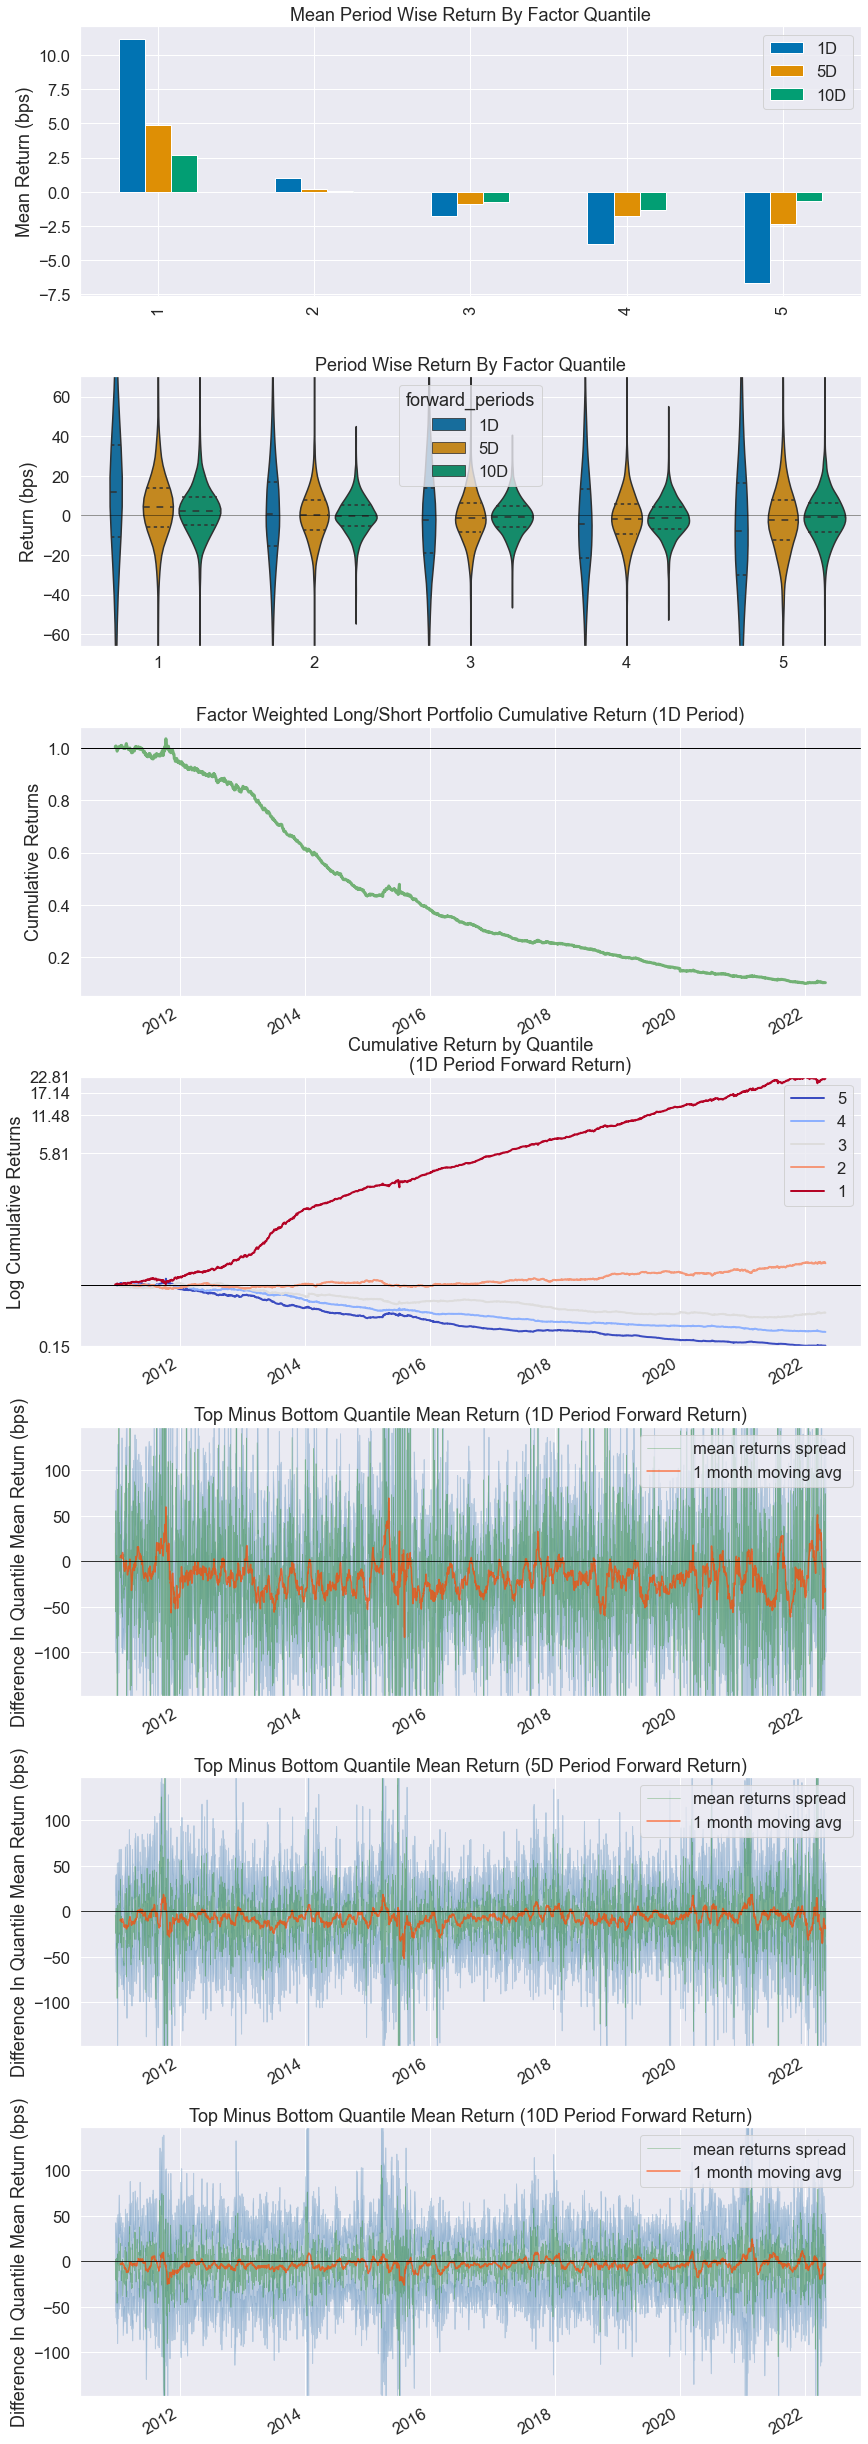

Information Analysis


,1D,5D,10D
IC Mean,-0.051,-0.036,-0.024
IC Std.,0.104,0.099,0.095
Risk-Adjusted IC,-0.493,-0.361,-0.255
t-stat(IC),-26.095,-19.085,-13.511
p-value(IC),0.000,0.000,0.000
IC Skew,0.193,-0.145,-0.186
IC Kurtosis,1.248,1.329,0.838


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

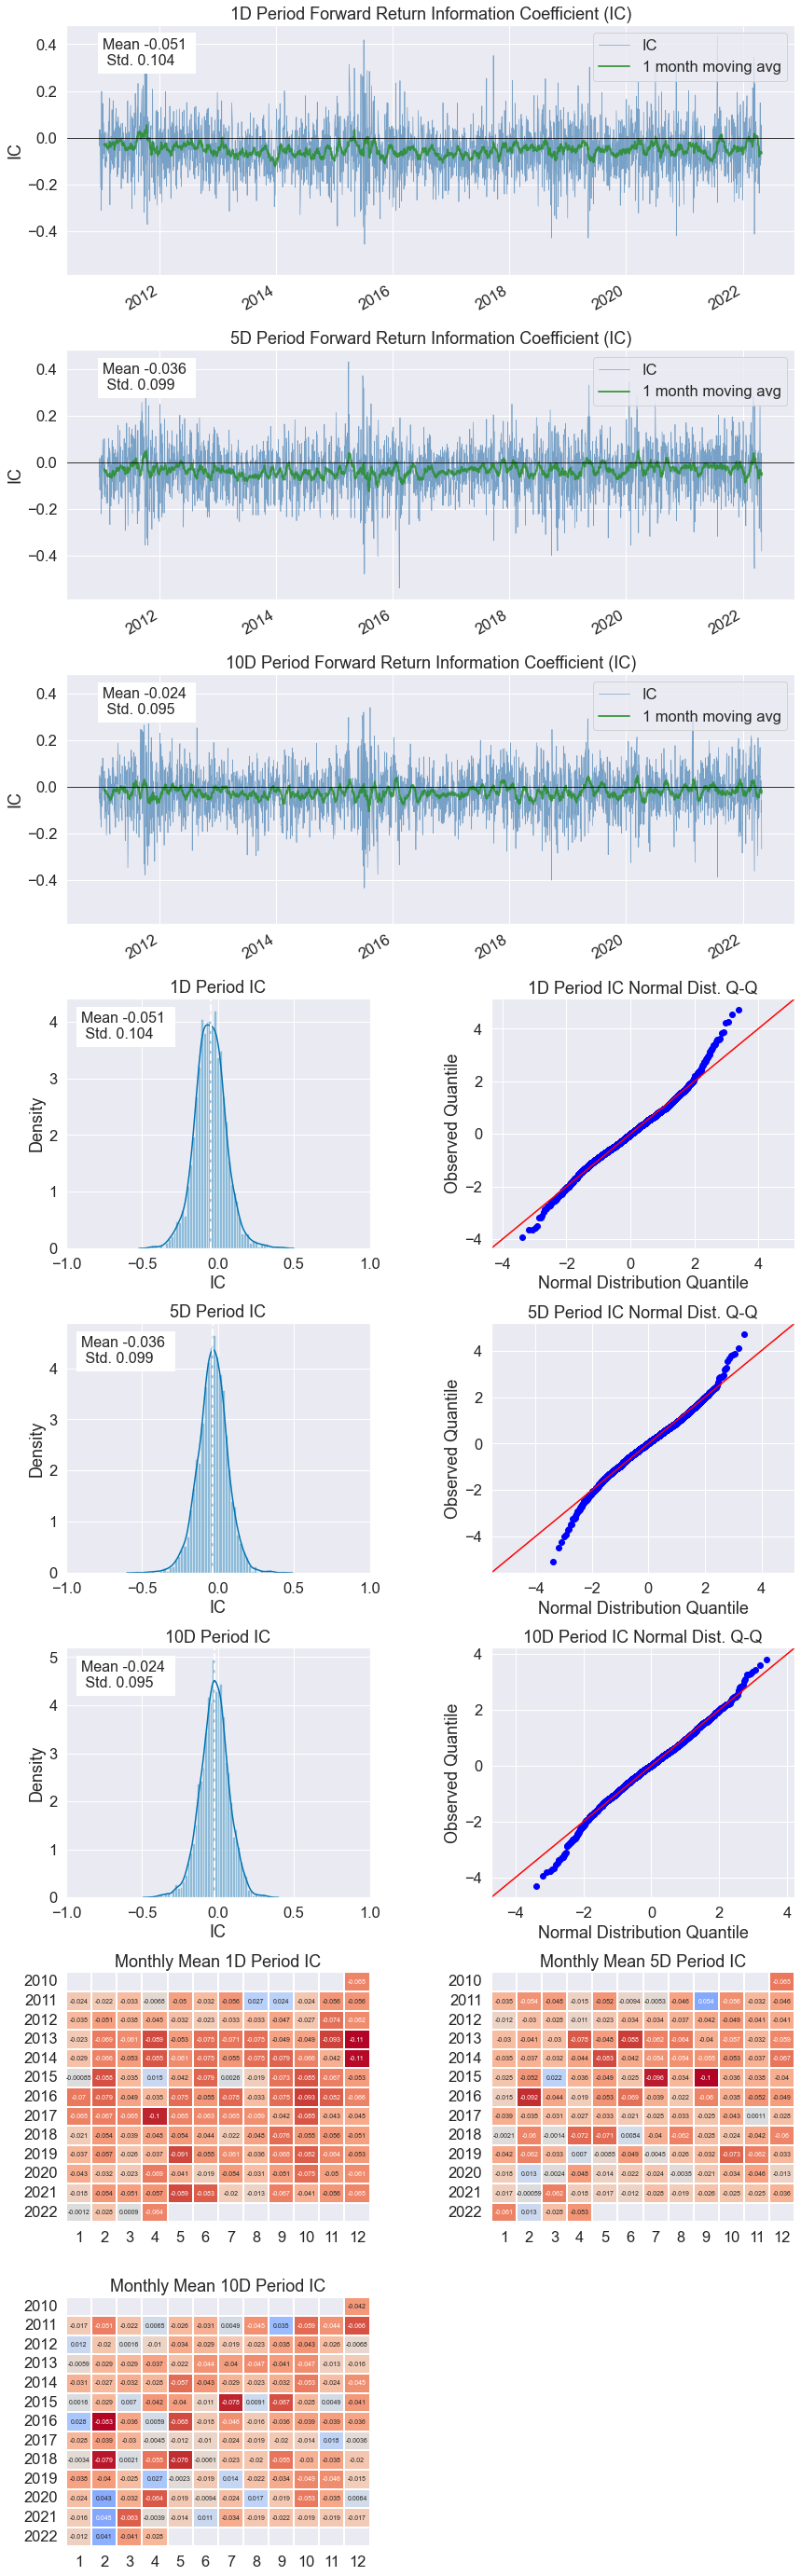

C:\ProgramData\Anaconda3\lib\site-packages\alphalens\utils.py:910: UserWarning: Skipping return periods that aren't exact multiples of days.
  warnings.warn(


AttributeError: 'Index' object has no attribute 'get_values'

In [64]:
alphalens.tears.create_full_tear_sheet(factor_return)

## IC分析

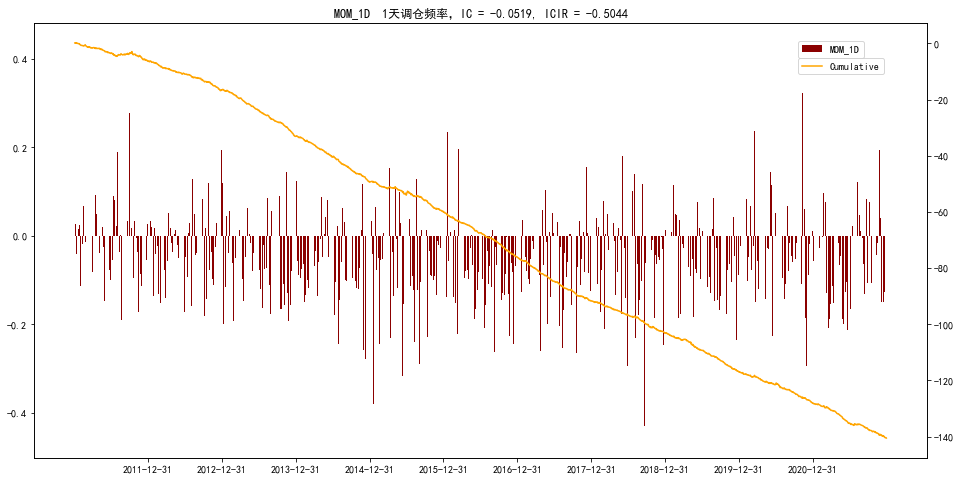

In [39]:
#计算一个因子的IC值
df_clean1 = df_clean.drop(["PE_TTM","PS_TTM","PB"],axis=1)["2011-1-3":"2021-12-31"].copy()
IC1 = IC_rank(df_clean1["Mom_1D"],df_clean1["Price"],period=1)

#IC画图
plot_IC(IC1,"MOM_1D",1)

In [34]:
#period多于一天时，依然每天算IC
#计算所有因子的IC值
factors = df_clean.drop(["Price","MktCap","class_code","PE_TTM","PS_TTM","PB"],axis=1)

IC_df = IC_rank_all(factors,df_clean["Price"],periods=[1,5,10,20])

IC_df.reset_index().set_index("Date")["2011-1-3":"2021-12-31"].groupby("period",sort=False).mean()

KeyboardInterrupt: 

In [44]:
#period多于一天时，试试不要每天算IC
#计算所有因子的IC值
factors = df_clean.drop(["Price","MktCap","class_code","PE_TTM","PS_TTM","PB"],axis=1)

IC_df = IC_rank_all(factors,df_clean["Price"],periods=[1,5,10,20])

IC_df.reset_index().set_index("Date")["2011-1-3":"2021-12-31"].groupby("period",sort=False).mean()

,Mom_1D,Mom_5D,Mom_20D,Mom_60D,Mom_120D,Mom_180D,Mom_240D,EP_TTM,SP_TTM,BP
period,,,,,,,,,,
1D,-0.051974,-0.038351,-0.015604,-0.005496,0.000611,0.003341,0.006719,0.009820,0.000299,0.004811
5D,-0.037200,-0.035304,-0.012158,0.000780,0.008200,0.013182,0.020310,0.011723,-0.002436,0.002526
10D,-0.020286,-0.021758,-0.008775,-0.001869,0.010724,0.015553,0.023828,0.015347,-0.000786,0.004866
20D,-0.009954,0.002835,-0.003700,0.003171,0.014528,0.022914,0.030374,0.018099,-0.000202,0.006376


In [140]:
IC_df.to_pickle('IC_df.pkl')

## 分组回测

In [8]:
#进行分组回测，绘制收益率表格
factors = df_clean.drop(["Price","MktCap","class_code","PE_TTM","PS_TTM","PB"],axis=1)
group_returns = Grouptest_Factors(factors.loc["2010-12-31":"2021-12-31"],
                                 df_clean.loc["2010-12-31":"2021-12-31","Price"],
                                 period=20,
                                 groups=5)
group_returns

group 1   group 2   group 3   group 4   group 5  group L-S
factor Date                                                                   
Mom_1D 2011-01-03  0.020094  0.019556  0.012427  0.014122  0.000522   0.019572
       2011-01-04  0.022859  0.018105  0.021990  0.019490  0.007639   0.015219
       2011-01-05  0.010081  0.002507  0.004504  0.005945  0.001335   0.008746
       2011-01-06  0.004703 -0.003532  0.005046  0.003327  0.003988   0.000715
       2011-01-07  0.001261 -0.005336 -0.000428  0.001190 -0.001417   0.002678
...                     ...       ...       ...       ...       ...        ...
BP     2021-12-13 -0.007457 -0.010610 -0.011611 -0.006393 -0.006786  -0.000671
       2021-12-14 -0.028416 -0.018656 -0.011159 -0.017737 -0.022022  -0.006394
       2021-12-15 -0.006587 -0.014983 -0.014189 -0.009405 -0.001306  -0.005281
       2021-12-16  0.012148  0.016914  0.007602  0.013954  0.007546   0.004602
       2021-12-17 -0.013785 -0.014409 -0.017338 -0.012975 -0.006720  -0.007065

[27000 rows x 6 columns]

In [9]:
#计算累计收益
df_bactest = cum_returns(group_returns)
df_bactest

group 1   group 2   group 3   group 4   group 5  group L-S
factor Date                                                                   
Mom_1D 2011-01-03  1.020094  1.019556  1.012427  1.014122  1.000522   1.019572
       2011-01-04  1.043412  1.038016  1.034689  1.033887  1.008165   1.035090
       2011-01-05  1.053931  1.040618  1.039350  1.040033  1.009511   1.044142
       2011-01-06  1.058888  1.036942  1.044595  1.043494  1.013538   1.044889
       2011-01-07  1.060223  1.031409  1.044148  1.044735  1.012102   1.047687
...                     ...       ...       ...       ...       ...        ...
BP     2021-12-13  4.780580  3.740029  2.892221  2.986522  3.511388   1.351777
       2021-12-14  4.644734  3.670253  2.859948  2.933550  3.434058   1.343134
       2021-12-15  4.614139  3.615261  2.819369  2.905961  3.429575   1.336041
       2021-12-16  4.670190  3.676409  2.840801  2.946510  3.455453   1.342189
       2021-12-17  4.605811  3.623434  2.791548  2.908278  3.432233   1.332706

[27000 rows x 6 columns]

<AxesSubplot:title={'center':'因子分组回测：Mom_1D'}, xlabel='Date'>

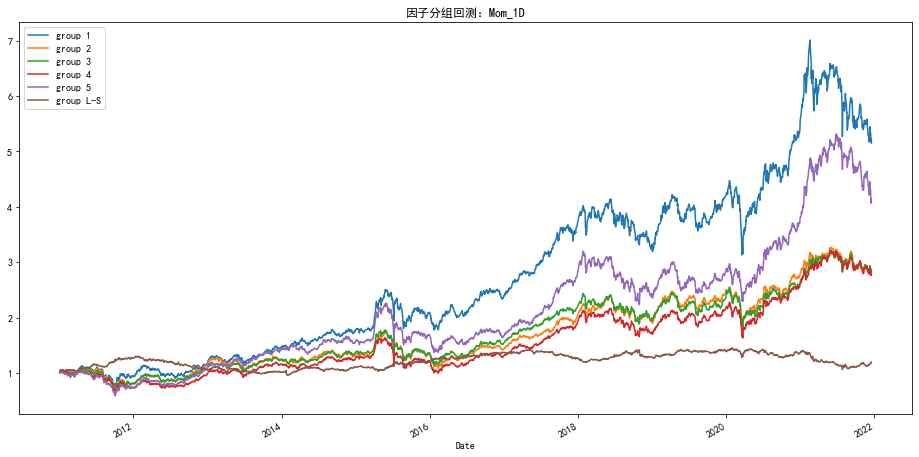

In [49]:
#单个因子画图
df_bactest.loc["Mom_1D"].plot(title="因子分组回测：Mom_1D",figsize=(16,8))

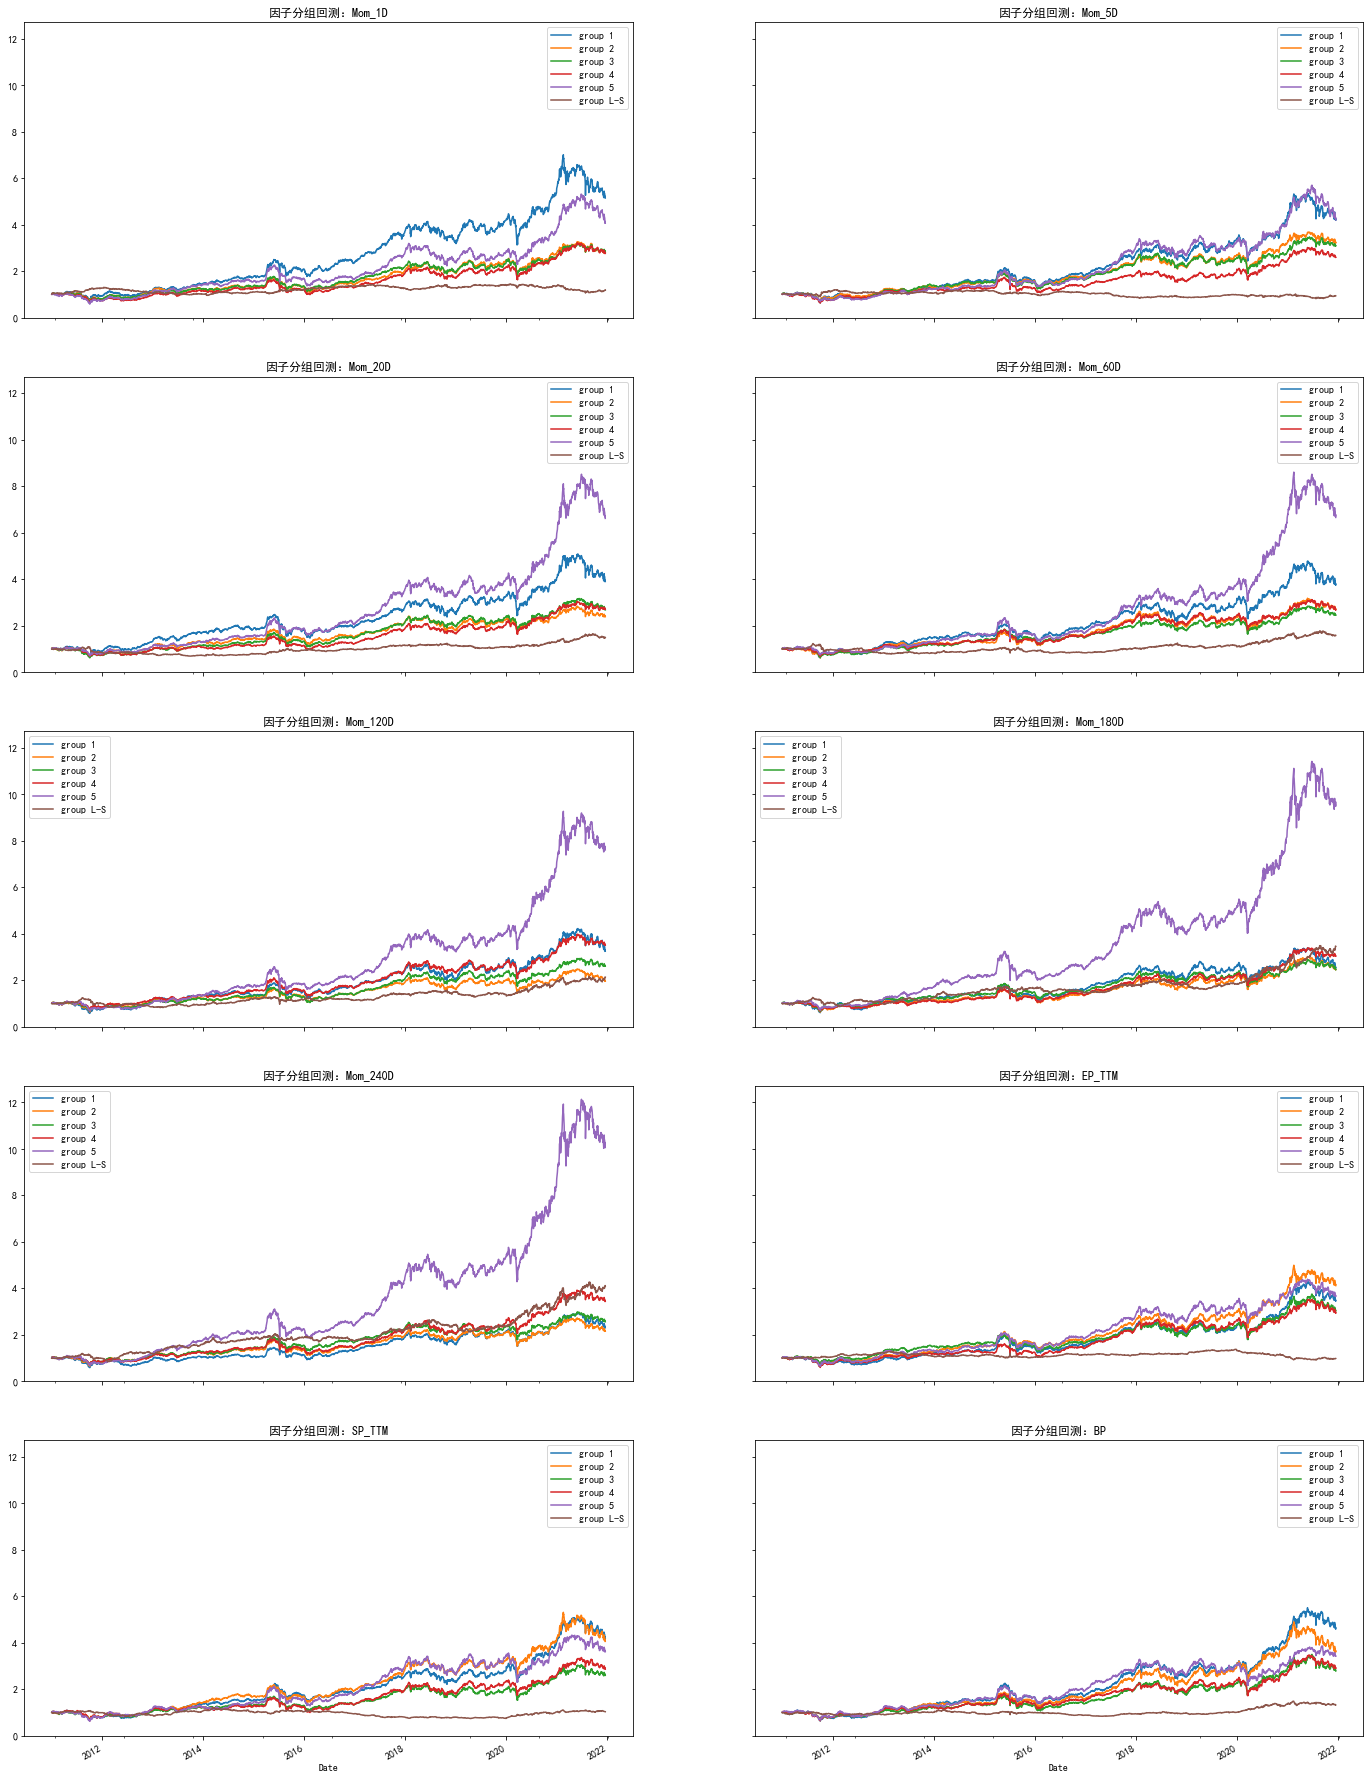

In [43]:
#画图
plot_groups(df_bactest)

# 多因子分析

## 读取数据

In [17]:
#读取数据
with open('df_clean.pkl','rb') as f:
    df_clean = pickle.load(f)
df_clean

Price        MktCap class_code    Mom_1D    Mom_5D  \
Date       stockcode                                                            
2010-12-20 0002.HK     41.304596  1.537526e+11       公用事业  0.747022  0.711285   
           0003.HK      5.630364  1.341658e+11       公用事业 -0.505346  0.437546   
           0004.HK      9.575779  1.498100e+11        房地产  1.063077 -0.740382   
           0005.HK     44.273949  1.401607e+12         金融 -0.261804  0.175126   
           0006.HK     22.643727  1.048990e+11       公用事业  0.213817 -0.013905   
...                          ...           ...        ...       ...       ...   
2022-05-17 9993.HK      4.350000  1.759674e+10        房地产 -0.433945 -0.903622   
           9995.HK     28.350000  1.542986e+10       医疗保健  1.257903  0.374410   
           9996.HK      6.730000  4.552806e+09       医疗保健  0.909253  2.515060   
           9997.HK      6.910000  8.604170e+09       医疗保健 -0.183027 -1.032800   
           9999.HK    151.200000  4.965394e+11       信息技术  0.743698  0.005793   

                       Mom_20D   Mom_60D  Mom_120D  Mom_180D  Mom_240D  \
Date       stockcode                                                     
2010-12-20 0002.HK    0.365618  0.467477  0.314126  0.519569  0.617539   
           0003.HK    0.021749  0.036312 -0.205486  0.221487  0.223284   
           0004.HK    0.192849  0.291886  0.796336  0.645124  0.603642   
           0005.HK    0.289143 -0.238181 -0.157114 -0.273616 -0.332623   
           0006.HK    0.039212  0.423115  0.089591  0.316961  0.483147   
...                        ...       ...       ...       ...       ...   
2022-05-17 9993.HK   -0.169695  0.962004  1.287084  0.941921  1.018861   
           9995.HK   -1.669104 -1.588059 -1.287356 -0.941986 -0.594069   
           9996.HK    0.070240 -1.257366 -0.805636 -0.713947 -0.458897   
           9997.HK    0.527131 -0.121846  0.680615  0.582439  0.294222   
           9999.HK   -0.015925  0.617762  0.138309  1.003854  0.142070   

                        PE_TTM    PS_TTM        PB    EP_TTM    SP_TTM  \
Date       stockcode                                                     
2010-12-20 0002.HK    0.023631  0.028869 -0.439545  0.521793 -0.222859   
           0003.HK    0.306750  0.175948  0.229805 -0.261485 -0.572560   
           0004.HK   -0.299391 -0.001427 -0.341284  0.226469 -0.316450   
           0005.HK   -0.058472 -0.044658 -1.008654 -0.273225  0.107879   
           0006.HK    0.116447  0.214618 -0.433876  0.129610 -0.621717   
...                        ...       ...       ...       ...       ...   
2022-05-17 9993.HK    0.000921  0.001451 -0.170500  0.017238 -0.335507   
           9995.HK    0.576145 -0.473412 -0.005896  0.192789 -0.196716   
           9996.HK   -0.128081 -0.494871 -0.342486 -0.510054 -0.366566   
           9997.HK    0.172936 -0.495731  0.079759  0.392006 -0.270718   
           9999.HK    0.466073  0.130430  0.730417  0.029123 -0.094061   

                            BP  
Date       stockcode            
2010-12-20 0002.HK    0.151596  
           0003.HK   -0.409418  
           0004.HK    0.210523  
           0005.HK    1.258949  
           0006.HK    0.112567  
...                        ...  
2022-05-17 9993.HK   -0.821877  
           9995.HK   -0.140797  
           9996.HK   -0.127900  
           9997.HK   -0.243099  
           9999.HK    0.174032  

[956182 rows x 16 columns]

In [18]:
#读取IC数据
with open('IC_df.pkl','rb') as f:
    IC_df = pickle.load(f)
IC_df

Mom_1D    Mom_5D   Mom_20D   Mom_60D  Mom_120D  Mom_180D  \
period Date                                                                     
1D     2010-12-20  0.033288 -0.060701 -0.033203 -0.059674  -0.01069 -0.026872   
       2010-12-21 -0.019879 -0.160782 -0.191781  0.000701  0.040724  0.095152   
       2010-12-22   -0.0368 -0.036354 -0.045632 -0.039836 -0.029124 -0.003229   
       2010-12-23  0.033941 -0.027821  0.060635  0.066484  0.099231  0.118814   
       2010-12-24  0.033743  0.027931  0.067068 -0.010898 -0.058568 -0.029138   
...                     ...       ...       ...       ...       ...       ...   
22D    2022-04-04 -0.304855 -0.202441  0.035741  0.138165  0.236316  0.245649   
       2022-04-06 -0.042283 -0.167468 -0.016671  0.106881   0.25515  0.256411   
       2022-04-07  0.186742 -0.095447 -0.019845  0.147284  0.255991  0.250671   
       2022-04-08 -0.106233 -0.150528  -0.05286   0.15058  0.239407  0.206898   
       2022-04-11  0.078315 -0.135461 -0.092024  0.054928  0.118248  0.081578   

                   Mom_240D    PE_TTM    PS_TTM        PB    EP_TTM    SP_TTM  \
period Date                                                                     
1D     2010-12-20  0.046173 -0.121622 -0.190647 -0.129094 -0.027194  0.089628   
       2010-12-21  0.169566 -0.172501  0.135861  0.044503  0.074956 -0.125496   
       2010-12-22 -0.088319 -0.024874 -0.014883  0.084057  0.053775 -0.040516   
       2010-12-23  0.130503  0.006445 -0.084223 -0.083996  0.121201 -0.082267   
       2010-12-24 -0.005942 -0.018494  -0.10756 -0.078855  0.075131  0.068765   
...                     ...       ...       ...       ...       ...       ...   
22D    2022-04-04  0.242997  0.023354   0.16439 -0.087618  0.123203 -0.029829   
       2022-04-06  0.259558  0.047926   0.18662 -0.082924  0.161825   0.01504   
       2022-04-07  0.272318  0.134089  0.179439 -0.045731  0.154333  0.031577   
       2022-04-08  0.239137  0.111863  0.171185  -0.02841  0.130855 -0.003395   
       2022-04-11  0.167015  0.102389  0.171877  0.038673  0.105331 -0.011445   

                         BP  
period Date                  
1D     2010-12-20  0.043061  
       2010-12-21 -0.032077  
       2010-12-22  0.002569  
       2010-12-23  0.063622  
       2010-12-24  0.118083  
...                     ...  
22D    2022-04-04  0.092639  
       2022-04-06  0.094724  
       2022-04-07  0.065235  
       2022-04-08  0.035004  
       2022-04-11 -0.030295  

[11190 rows x 13 columns]

In [53]:
#提取Benchmark数据
with open('Benchmark.pkl','rb') as f:
    Benchmark = pickle.load(f)
Benchmark

,Benchmark
Dates,
2010-01-04,21823.28
2010-01-05,22279.58
2010-01-06,22416.67
2010-01-07,22269.45
2010-01-08,22296.75
...,...
2022-05-17,20602.52
2022-05-18,20644.28
2022-05-19,20120.68


## 计算合成因子

In [6]:
# #测试：假设选择全部因子来进行多因子测试
# factors = df_clean.drop(["Price","MktCap","class_code"],axis=1)
# factors

Mom_1D    Mom_5D   Mom_20D   Mom_60D  Mom_120D  \
Date       stockcode                                                     
2010-12-20 0002.HK    0.747022  0.711285  0.365618  0.467477  0.314126   
           0003.HK   -0.505346  0.437546  0.021749  0.036312 -0.205486   
           0004.HK    1.063077 -0.740382  0.192849  0.291886  0.796336   
           0005.HK   -0.261804  0.175126  0.289143 -0.238181 -0.157114   
           0006.HK    0.213817 -0.013905  0.039212  0.423115  0.089591   
...                        ...       ...       ...       ...       ...   
2022-05-17 9993.HK   -0.433945 -0.903622 -0.169695  0.962004  1.287084   
           9995.HK    1.257903  0.374410 -1.669104 -1.588059 -1.287356   
           9996.HK    0.909253  2.515060  0.070240 -1.257366 -0.805636   
           9997.HK   -0.183027 -1.032800  0.527131 -0.121846  0.680615   
           9999.HK    0.743698  0.005793 -0.015925  0.617762  0.138309   

                      Mom_180D  Mom_240D    PE_TTM    PS_TTM        PB  
Date       stockcode                                                    
2010-12-20 0002.HK    0.519569  0.617539  0.023631  0.028869 -0.439545  
           0003.HK    0.221487  0.223284  0.306750  0.175948  0.229805  
           0004.HK    0.645124  0.603642 -0.299391 -0.001427 -0.341284  
           0005.HK   -0.273616 -0.332623 -0.058472 -0.044658 -1.008654  
           0006.HK    0.316961  0.483147  0.116447  0.214618 -0.433876  
...                        ...       ...       ...       ...       ...  
2022-05-17 9993.HK    0.941921  1.018861  0.000921  0.001451 -0.170500  
           9995.HK   -0.941986 -0.594069  0.576145 -0.473412 -0.005896  
           9996.HK   -0.713947 -0.458897 -0.128081 -0.494871 -0.342486  
           9997.HK    0.582439  0.294222  0.172936 -0.495731  0.079759  
           9999.HK    1.003854  0.142070  0.466073  0.130430  0.730417  

[956182 rows x 10 columns]

In [34]:
# #调整因子值
# adjust_factors(factors,pd.Series([-1,1,1,1,1,1,1,1,1,1]))

Mom_1D    Mom_5D   Mom_20D   Mom_60D  Mom_120D  \
Date       stockcode                                                     
2010-12-20 0002.HK   -0.747022  0.711285  0.365618  0.467477  0.314126   
           0003.HK    0.505346  0.437546  0.021749  0.036312 -0.205486   
           0004.HK   -1.063077 -0.740382  0.192849  0.291886  0.796336   
           0005.HK    0.261804  0.175126  0.289143 -0.238181 -0.157114   
           0006.HK   -0.213817 -0.013905  0.039212  0.423115  0.089591   
...                        ...       ...       ...       ...       ...   
2022-05-17 9993.HK    0.433945 -0.903622 -0.169695  0.962004  1.287084   
           9995.HK   -1.257903  0.374410 -1.669104 -1.588059 -1.287356   
           9996.HK   -0.909253  2.515060  0.070240 -1.257366 -0.805636   
           9997.HK    0.183027 -1.032800  0.527131 -0.121846  0.680615   
           9999.HK   -0.743698  0.005793 -0.015925  0.617762  0.138309   

                      Mom_180D  Mom_240D    PE_TTM    PS_TTM        PB  
Date       stockcode                                                    
2010-12-20 0002.HK    0.519569  0.617539  0.023631  0.028869 -0.439545  
           0003.HK    0.221487  0.223284  0.306750  0.175948  0.229805  
           0004.HK    0.645124  0.603642 -0.299391 -0.001427 -0.341284  
           0005.HK   -0.273616 -0.332623 -0.058472 -0.044658 -1.008654  
           0006.HK    0.316961  0.483147  0.116447  0.214618 -0.433876  
...                        ...       ...       ...       ...       ...  
2022-05-17 9993.HK    0.941921  1.018861  0.000921  0.001451 -0.170500  
           9995.HK   -0.941986 -0.594069  0.576145 -0.473412 -0.005896  
           9996.HK   -0.713947 -0.458897 -0.128081 -0.494871 -0.342486  
           9997.HK    0.582439  0.294222  0.172936 -0.495731  0.079759  
           9999.HK    1.003854  0.142070  0.466073  0.130430  0.730417  

[956182 rows x 10 columns]

In [58]:
# #测试
# #等权构建因子
# weighted_factor1 = factors.mean(axis=1)
# weighted_factor1

Date        stockcode
2010-12-20  0002.HK      0.335559
            0003.HK      0.094205
            0004.HK      0.221043
            0005.HK     -0.191085
            0006.HK      0.144913
                           ...   
2022-05-17  9993.HK      0.253448
            9995.HK     -0.435142
            9996.HK     -0.070673
            9997.HK      0.050370
            9999.HK      0.396248
Length: 956182, dtype: float64

In [59]:
# #测试
# #不等权但权重固定，构建因子
# n = factors.shape[1]
# x = 1/n
# weight = pd.Series(x,index=factors.columns)
# weighted_factor2 = factors.dot(weight)
# weighted_factor2

Date        stockcode
2010-12-20  0002.HK      0.335559
            0003.HK      0.094205
            0004.HK      0.221043
            0005.HK     -0.191085
            0006.HK      0.144913
                           ...   
2022-05-17  9993.HK      0.253448
            9995.HK     -0.435142
            9996.HK     -0.070673
            9997.HK      0.050370
            9999.HK      0.396248
Length: 956182, dtype: float64

In [74]:
# #测试
# #计算12期移动平均，作为权重来计算因子
# IC_mean_df = IC_df.rolling(12).mean().dropna()   #移动平均
# IC_mean_df

# weight = IC_mean_df.div(IC_mean_df.sum(axis=1),axis=0)   #计算权重
# weight

,Mom_1D,Mom_5D,Mom_20D,Mom_60D,Mom_120D,Mom_180D,Mom_240D,PE_TTM,PS_TTM,PB
2011-01-06,0.114492,0.213080,0.229105,0.075202,-0.010806,-0.027281,-0.086365,0.115798,0.203669,0.173106
2011-01-07,0.130194,0.216550,0.230360,0.052957,-0.008726,-0.065524,-0.076001,0.109905,0.241128,0.169157
2011-01-10,0.166609,0.200058,0.158107,0.042858,0.014432,-0.021329,-0.010030,0.056584,0.255108,0.137603
2011-01-11,0.164220,0.259464,0.195905,-0.004436,-0.039309,-0.071573,-0.121799,0.053481,0.334195,0.229852
2011-01-12,0.127675,0.175078,0.166201,0.053580,0.050581,0.038385,0.002305,0.039505,0.194419,0.152270
...,...,...,...,...,...,...,...,...,...,...
2022-05-11,-0.805739,-2.873314,-0.146060,-0.017732,0.810195,1.039798,1.643939,0.532013,0.694980,0.121921
2022-05-12,-0.127088,-0.454035,0.098443,0.198955,0.354426,0.340705,0.437109,0.123252,0.106731,-0.078496
2022-05-13,0.492189,1.828436,0.295074,0.195742,-0.226212,-0.333251,-0.698074,-0.359358,-0.163963,-0.030582
2022-05-16,0.084548,1.124167,0.258292,0.131289,-0.077142,-0.157755,-0.304448,-0.084269,-0.049718,0.075037


## 回测

In [56]:
#因子权重不变的回测，选定两个因子"Mom_240D"和"EP_TTM"，持仓排名前20%，2011年到2022年，20个交易日（一个月）调仓
factors = df_clean[["Mom_240D","EP_TTM"]]
backtest_result,backtest_cum_result = backtest_unchanged_weight(factors["2010-12-31":"2021-12-31"],
                                                                df_clean["Price"]["2010-12-31":"2021-12-31"],
                                                                Benchmark=Benchmark["2010-12-30":"2021-12-31"],
                                                                period=20,
                                                                invest_percentage=0.2)
print(backtest_result)
print(backtest_cum_result)

              Result  Benchmark
2010-12-31  0.000000   0.000000
2011-01-03  0.010682   0.017391
2011-01-04  0.019507   0.009918
2011-01-05  0.011880   0.003775
2011-01-06  0.001862   0.001199
...              ...        ...
2021-12-13 -0.014185  -0.001714
2021-12-14 -0.022223  -0.013301
2021-12-15 -0.006340  -0.009104
2021-12-16  0.015186   0.002337
2021-12-17 -0.015037  -0.012050

[2701 rows x 2 columns]
              Result  Benchmark
2010-12-31  1.000000   1.000000
2011-01-03  1.010682   1.017391
2011-01-04  1.030398   1.027481
2011-01-05  1.042638   1.031359
2011-01-06  1.044580   1.032595
...              ...        ...
2021-12-13  9.040012   1.039901
2021-12-14  8.839113   1.026069
2021-12-15  8.783072   1.016727
2021-12-16  8.916450   1.019103
2021-12-17  8.782371   1.006823

[2701 rows x 2 columns]


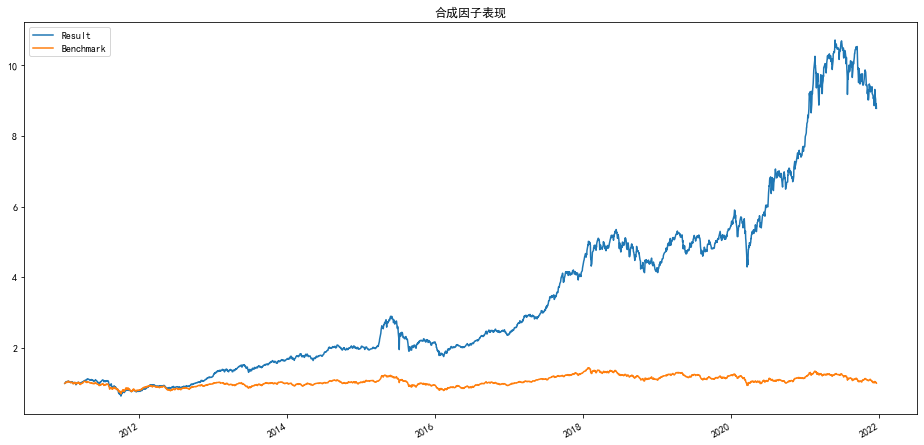

In [57]:
#画图
plot_backtest(backtest_cum_result)

In [36]:
# #测试：选定两个因子，一个月调仓
# factors = df_clean[["Mom_240D","EP_TTM"]]
# backtest_result,backtest_cum_result = backtest_unchanged_weight(factors,df_clean["Price"],
#                                                                 Benchmark=Benchmark,
#                                                                 period=22)
# plot_backtest(backtest_cum_result)

In [37]:
# #测试：全部股票买入，一个月调仓
# factors = df_clean[["Mom_240D","EP_TTM"]]
# backtest_result,backtest_cum_result = backtest_unchanged_weight(factors,df_clean["Price"],
#                                                                 Benchmark=Benchmark,
#                                                                 invest_percentage=1,
#                                                                 period=22)
# plot_backtest(backtest_cum_result)

## 策略评价

In [58]:
#因子权重不变的回测，选定两个因子"Mom_240D"和"EP_TTM"，持仓排名前20%，2011年到2022年，20个交易日（一个月）调仓
ind = Indicators(backtest_result.iloc[:,0],backtest_cum_result.iloc[:,0])

#最大回撤
print("最大回撤是{0[0]:.2%}，开始日期：{0[1]:%Y-%m-%d}，结束日期：{0[2]:%Y-%m-%d}".format(ind.max_down()))

#总收益率
print("总收益率是{:.2%}".format(ind.total_return()))

#年化收益率
print("年化收益率是{:.2%}".format(ind.annual_return()))

#波动率
print("波动率是{:.2%}".format(ind.volatility()))

#夏普比率
print("夏普比率是{:.2f}".format(ind.sharpe_ratio()))

#胜率
print("胜率是{:.2%}".format(ind.win_rate(Benchmark=backtest_result.iloc[:,1])))

最大回撤是43.29%，开始日期：2011-04-21，结束日期：2011-10-04
总收益率是778.24%
年化收益率是22.28%
波动率是22.07%
夏普比率是0.89
胜率是55.68%


In [53]:
# #测试：投资全部标的，等权
# ind = Indicators(backtest_result.iloc[:,0],backtest_cum_result.iloc[:,0])
# 最大回撤
# #ind.max_down()
# print("最大回撤是{0[0]:.2%}，开始日期：{0[1]:%Y-%m-%d}，结束日期：{0[2]:%Y-%m-%d}".format(ind.max_down()))

# #年化收益率
# # ind.annual_return()
# print("年化收益率是{:.2%}".format(ind.annual_return()))

# #波动率
# # ind.volatility()
# print("波动率是{:.2%}".format(ind.volatility()))

# #夏普比率
# # ind.sharpe_ratio()
# print("夏普比率是{:.2f}".format(ind.sharpe_ratio(rf=0.026)))

最大回撤是38.44%，开始日期：2011-04-21，结束日期：2011-10-04
年化收益率是10.42%
波动率是20.35%
夏普比率是0.38


# 使用Backtrader进行更真实的分析

## 这一次进行更真实的回测，主要有如下变动：
1.计入佣金和其他收费
2.考虑恒生综合指数的历史变动
3.第二日开盘价成交

In [2]:
#这一次计入恒生综合指数的历史变动，由于因子值计算需要取出每一天的横截面数据，因此当股票池不同了，数据清洗就要重新做

## 整合数据

In [ ]:
#提取港股成分股数据(恒生综指历史股票部分 + 恒生综指5月成分股部分)
#提取港股成分股数据(恒生综指历史股票部分)
stock_df_all = pd.DataFrame()

columns = ['open','high','low','close','volume']
for c in columns:
    # c = columns[0]
    a = pd.read_excel(r'D:\Google Drive\pythonProjects\港股\原数据\恒生综指历史股票\OHLCV.xlsx',index_col=0,sheet_name=c,parse_dates=True)
    a = a.stack().reset_index()
    a.columns = ['Date','code',c]
    a.set_index(keys=['Date','code'],inplace=True)
    stock_df_all = pd.concat([stock_df_all,a],axis=1)
    
columns = ['MktCap','PE_TTM','PS_TTM','PB']
for c in columns:
    # c = columns[0]
    a = pd.read_excel(r'D:\Google Drive\pythonProjects\港股\原数据\恒生综指历史股票\MktCap PE_TTM PS_TTM PB.xlsx',index_col=0,sheet_name=c,parse_dates=True)
    a = a.stack().reset_index()
    a.columns = ['Date','code',c]
    a.set_index(keys=['Date','code'],inplace=True)
    stock_df_all = pd.concat([stock_df_all,a],axis=1)
    
stock_df_all.sort_index(inplace=True)

#提取港股成分股数据(恒生综指5月成分股部分)
with open('stock_price_OHLCV.pkl', 'rb') as f:
    stock_df_May = pickle.load(f)
    
stock_df_May = stock_df_May.set_index(['Date','code']).sort_index()

with open(r'D:\Google Drive\pythonProjects\港股\df_raw.pkl', 'rb') as f:
    stock_df_raw = pickle.load(f)

stock_df_raw.index.name='code'
stock_df_raw = stock_df_raw.reset_index().set_index(['Date','code']).sort_index()[['MktCap','PE_TTM','PS_TTM','PB']]

stock_df_May = pd.concat([stock_df_May,stock_df_raw],axis=1)

#两部分合并
stock_df_all = pd.concat([stock_df_all,stock_df_May]).sort_index()
stock_df_all = stock_df_all.reset_index().drop_duplicates(subset=['Date','code'],keep='first')
stock_df_all.volume.replace(to_replace='--',value=np.nan,inplace=True)
stock_df_all.volume = stock_df_all.volume.astype(float)

#提取行业信息
Info = pd.read_excel(r'D:\Google Drive\pythonProjects\港股\原数据\基本信息包含历史成分股.xlsx')
Info.columns = ['code','name','class_code']
stock_df_all = pd.merge(stock_df_all,Info[['code','class_code']],how='left',on='code')
stock_df_all

stock_df_all.to_pickle('stock_df_all.pkl')

In [ ]:
#将恒生综指历史变动写入stock_df_all
#提取恒生综指历史变动
hist_HSCI = pd.read_excel(r'Constituent Changes in Hang Seng Composite Index.xlsx',parse_dates=[0])
hist_HSCI['Stock Code'] = hist_HSCI['Stock Code'].apply(lambda x:'{:0>4d}.HK'.format(x))
hist_HSCI['Change'] = hist_HSCI['Change'].replace({'Delete 刪除':'Delete','Add 加入':'Add'})
hist_HSCI = hist_HSCI[['Effective Date','Stock Code','Change']]
#只提取2022-5-18 之前的变动
hist_HSCI = hist_HSCI[hist_HSCI['Effective Date']<'2022-5-18']

#加上一列来表达当时是否为成分股,True表示在成分股中，False表示不在成分股中
with open('stock_df_all.pkl','rb') as f:
    stock_df_all = pickle.load(f)
stock_df_all['is_Constituents'] = False
#获取5月份的成分股名单
with open('D:\Google Drive\pythonProjects\港股\df_raw.pkl','rb') as f:
    df_raw = pickle.load(f)
stock_list = df_raw.index.drop_duplicates().to_list()
stock_list
#5月份名单中的股份的is_Constituents设为True
stock_df_all.set_index('code',inplace=True)
for s in stock_list:
    stock_df_all.loc[s,'is_Constituents'] = True
stock_df_all.reset_index(inplace=True)

#根据hist_HSCI将成分股变动写入stock_df_all
#从恒生综指历史变动中一行一行查找
for s in range(0,len(hist_HSCI)):
    # s=0
    if hist_HSCI.iloc[s]['Change'] == 'Delete': #当某一天某股票从指数中删除时，之前所有日期此股票的is_Constituents设为True
        date_change = hist_HSCI.iloc[s]['Effective Date']
        Code = hist_HSCI.iloc[s]['Stock Code']
        stock_df_all.loc[(stock_df_all['code']==Code)&(stock_df_all['Date']<date_change),'is_Constituents'] = True
    elif hist_HSCI.iloc[s]['Change'] == 'Add':  #当某一天某股票从指数中删除时，之前所有日期此股票的is_Constituents设为Fale
        date_change = hist_HSCI.iloc[s]['Effective Date']
        Code = hist_HSCI.iloc[s]['Stock Code']
        stock_df_all.loc[(stock_df_all['code']==Code)&(stock_df_all['Date']<date_change),'is_Constituents'] = False

stock_df_all.to_pickle('stock_df_all.pkl')   
stock_df_all

In [ ]:
#计算因子 Mom_240D 和 EP_TTM
with open('stock_df_all.pkl','rb') as f:
    stock_df_all = pickle.load(f)
    
Price = stock_df_all[['code','Date','close']].pivot(index='Date',columns='code',values='close')
Mom_240D = Price.pct_change(240)
Mom_240D = Mom_240D.stack()
Mom_240D.name = 'Mom_240D'
Mom_240D = Mom_240D.reset_index()
stock_df_all = pd.merge(stock_df_all,Mom_240D,how='right',on=['Date','code'])

stock_df_all['EP_TTM'] = 1/stock_df_all['PE_TTM']

stock_df_all = stock_df_all[['code','Date','open','high','low','close','volume','MktCap','Mom_240D','EP_TTM','class_code','is_Constituents']]

stock_df_all.to_pickle('stock_df_all.pkl')
stock_df_all

## 清洗数据

In [ ]:
with open('stock_df_all.pkl','rb') as f:
    stock_df_all = pickle.load(f)
    
#将缺失值删除
stock_df_all.dropna(inplace=True)
stock_df_all.isnull().sum().sort_values(ascending=False)

#查看负值，由于EP和Mom可以是负，所以不用调整
(stock_df_all.drop(columns=['code','Date','class_code','is_Constituents'])<0).sum()


In [ ]:
# 清洗每一天的因子值
class_clean = clean()
stock_df_all = stock_df_all.reset_index().set_index(["Date","code"]).sort_index()
stock_df_all_clean= pd.DataFrame()
#设定交易日索引
tradedates = stock_df_all.index.get_level_values(0).drop_duplicates().sort_values()
#抽出每一天做清洗
for date in tradedates:
    df = stock_df_all.loc[[date],:].copy()
    df[df==np.inf] =np.NaN
    df.dropna(axis = 0,inplace = True)
    factors = df[['Mom_240D','EP_TTM']]
    #因子所在列做数据清洗
    factors = factors.apply(func=class_clean.filter_extreme_by_sigma)
    factors = factors.apply(func=class_clean.standardize)
    factors = factors.apply(func=class_clean.neutralization,args=(df["MktCap"],df["class_code"]))    
    df = pd.concat([df.drop(columns=['Mom_240D','EP_TTM']),factors],axis=1)
    #清洗完成合并到新的dataframe
    stock_df_all_clean = pd.concat([stock_df_all_clean,df])
stock_df_all_clean

In [ ]:
stock_df_all_clean.reset_index(inplace=True)
stock_df_all_clean.to_pickle('stock_df_all_clean.pkl')

## 回测

2010-12-20,Porfolio Value: 10,000,000, Total Return: 0.00%, Return vs last period: 0.00%
2010-12-20,Rebalancing Portfolio, Stock_pool: 0
2011-01-03,Porfolio Value: 10,000,000, Total Return: 0.00%, Return vs last period: 0.00%
2011-01-03,Rebalancing Portfolio, Stock_pool: 58
2011-01-03,Order Placed. Close position: 0, Sell Part: 0, Buy Part: 58
2011-02-01,Porfolio Value: 9,621,105, Total Return: -3.79%, Return vs last period: -3.79%
2011-02-01,Rebalancing Portfolio, Stock_pool: 58
2011-02-01,Order Placed. Close position: 10, Sell Part: 31, Buy Part: 27
2011-03-01,Porfolio Value: 9,238,952, Total Return: -7.61%, Return vs last period: -3.97%
2011-03-01,Rebalancing Portfolio, Stock_pool: 59
2011-03-01,Order Placed. Close position: 9, Sell Part: 29, Buy Part: 30
2011-04-01,Porfolio Value: 9,547,143, Total Return: -4.53%, Return vs last period: 3.34%
2011-04-01,Rebalancing Portfolio, Stock_pool: 63
2011-04-01,Order Placed. Close position: 19, Sell Part: 33, Buy Part: 30
2011-05-03,Porfolio 

2014-04-01,Porfolio Value: 12,044,811, Total Return: 20.45%, Return vs last period: -0.14%
2014-04-01,Rebalancing Portfolio, Stock_pool: 70
2014-04-01,Order Placed. Close position: 16, Sell Part: 37, Buy Part: 33
2014-05-02,Porfolio Value: 11,309,329, Total Return: 13.09%, Return vs last period: -6.11%
2014-05-02,Rebalancing Portfolio, Stock_pool: 70
2014-05-02,Order Placed. Close position: 11, Sell Part: 37, Buy Part: 33
2014-06-03,Porfolio Value: 11,408,891, Total Return: 14.09%, Return vs last period: 0.88%
2014-06-03,Rebalancing Portfolio, Stock_pool: 70
2014-06-03,Order Placed. Close position: 9, Sell Part: 37, Buy Part: 33
2014-07-02,Porfolio Value: 11,541,466, Total Return: 15.41%, Return vs last period: 1.16%
2014-07-02,Rebalancing Portfolio, Stock_pool: 71
2014-07-02,Order Placed. Close position: 13, Sell Part: 37, Buy Part: 34
2014-08-01,Porfolio Value: 12,230,662, Total Return: 22.31%, Return vs last period: 5.97%
2014-08-01,Rebalancing Portfolio, Stock_pool: 71
2014-08-01,O

2017-07-03,Porfolio Value: 12,944,809, Total Return: 29.45%, Return vs last period: 4.82%
2017-07-03,Rebalancing Portfolio, Stock_pool: 91
2017-07-03,Order Placed. Close position: 15, Sell Part: 41, Buy Part: 50
2017-08-01,Porfolio Value: 13,642,970, Total Return: 36.43%, Return vs last period: 5.39%
2017-08-01,Rebalancing Portfolio, Stock_pool: 90
2017-08-01,Order Placed. Close position: 15, Sell Part: 33, Buy Part: 57
2017-09-01,Porfolio Value: 13,985,191, Total Return: 39.85%, Return vs last period: 2.51%
2017-09-01,Rebalancing Portfolio, Stock_pool: 91
2017-09-01,Order Placed. Close position: 22, Sell Part: 40, Buy Part: 51
2017-10-03,Porfolio Value: 15,068,531, Total Return: 50.69%, Return vs last period: 7.75%
2017-10-03,Rebalancing Portfolio, Stock_pool: 94
2017-10-03,Order Placed. Close position: 20, Sell Part: 40, Buy Part: 54
2017-11-01,Porfolio Value: 14,972,323, Total Return: 49.72%, Return vs last period: -0.64%
2017-11-01,Rebalancing Portfolio, Stock_pool: 94
2017-11-01,O

2020-10-05,Porfolio Value: 16,406,651, Total Return: 64.07%, Return vs last period: -3.17%
2020-10-05,Rebalancing Portfolio, Stock_pool: 91
2020-10-05,Order Placed. Close position: 18, Sell Part: 34, Buy Part: 57
2020-11-02,Porfolio Value: 16,241,506, Total Return: 62.42%, Return vs last period: -1.01%
2020-11-02,Rebalancing Portfolio, Stock_pool: 92
2020-11-02,Order Placed. Close position: 17, Sell Part: 43, Buy Part: 49
2020-12-01,Porfolio Value: 17,708,608, Total Return: 77.09%, Return vs last period: 9.03%
2020-12-01,Rebalancing Portfolio, Stock_pool: 93
2020-12-01,Order Placed. Close position: 18, Sell Part: 41, Buy Part: 52
2021-01-04,Porfolio Value: 19,041,188, Total Return: 90.41%, Return vs last period: 7.53%
2021-01-04,Rebalancing Portfolio, Stock_pool: 94
2021-01-04,Order Placed. Close position: 19, Sell Part: 38, Buy Part: 56
2021-02-01,Porfolio Value: 20,391,134, Total Return: 103.91%, Return vs last period: 7.09%
2021-02-01,Rebalancing Portfolio, Stock_pool: 94
2021-02-01

<IPython.core.display.Javascript object>


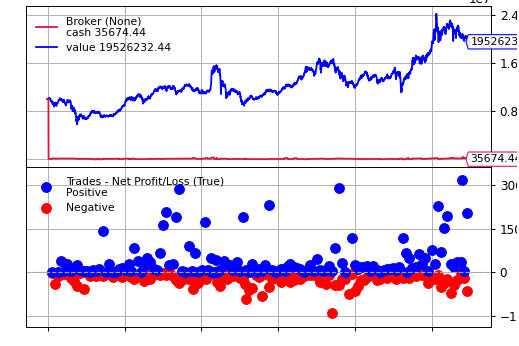

[[<Figure size 432x288 with 2 Axes>]]

In [6]:
#Backtrader程序
#增加新的线到Data Feeds
class PandasDataExtend(PandasData):
    #存放合成后的因子
    lines = ('factor', 'is_Constituents',)
    #暂定第八列
    params = (('factor', 7), ('is_Constituents',8),)


'''可能要改commission函数'''


class MyStockCommissionScheme(bt.CommInfoBase):
    '''
    本佣金模式下，买入股票仅支付佣金，卖出股票支付佣金和印花税.    
    '''
    params = dict(
        commission=0.000668,  #佣金率，*成交金額
        stamp_duty=0.0013,  #印花税率，0.13%*成交金額，每次成交不足1港元作1 港元計
        Trading_Tariff=0.5,  #交易系統使用費，每次成交0.50 港元
        Settlement_Fees=0.00002,  #0.002%*成交金額，每次成交最低2 港元，最高100 港元
        Trading_Fees=0.00005,  #0.005%*成交金額，每次成交最低0.01 港元
        SFC_Transaction_Levy=0.000027,  #0.0027%*成交金額，每次成交最低0.01 港元
        FRC_Transaction_Levy=0.0000015,  #0.00015%*交易金額
        stocklike=True,  #股票类资产，不考虑保证金
        commtype=bt.CommInfoBase.COMM_PERC,  #按百分比
        minCommission=100,  #最小佣金
        platFee=0  #平台费用
    )

    def _getcommission(self, size, price, pseudoexec):
        '''
        size>0，买入操作。
        size<0，卖出操作。
        '''
        if size > 0:  # 买入
            return sum([
                max(size * price * self.p.commission, self.p.minCommission), #佣金率，*成交金額，设定最小佣金
                self.p.platFee,    #平台费用
                math.ceil(size * price * self.p.stamp_duty),  #印花税率，0.13%*成交金額，每次成交不足1港元作1 港元計
                self.p.Trading_Tariff,   #交易系統使用費，每次成交0.50 港元
                np.clip(size * price * self.p.Settlement_Fees,2,100),  #0.002%*成交金額，每次成交最低2 港元，最高100 港元
                max(size * price * self.p.Trading_Fees,0.01),   #0.005%*成交金額，每次成交最低0.01 港元
                max(size * price * self.p.SFC_Transaction_Levy,0.01),  #0.0027%*成交金額，每次成交最低0.01 港元
                size * price * self.p.FRC_Transaction_Levy    #0.00015%*交易金額
            ])
        elif size < 0:  # 卖出
            return sum([
                max(abs(size) * price * self.p.commission, self.p.minCommission), #佣金率，*成交金額，设定最小佣金
                self.p.platFee,    #平台费用
                math.ceil(abs(size) * price * self.p.stamp_duty),  #印花税率，0.13%*成交金額，每次成交不足1港元作1 港元計
                self.p.Trading_Tariff,   #交易系統使用費，每次成交0.50 港元
                np.clip(abs(size) * price * self.p.Settlement_Fees,2,100),  #0.002%*成交金額，每次成交最低2 港元，最高100 港元
                max(abs(size) * price * self.p.Trading_Fees,0.01),   #0.005%*成交金額，每次成交最低0.01 港元
                max(abs(size) * price * self.p.SFC_Transaction_Levy,0.01),  #0.0027%*成交金額，每次成交最低0.01 港元
                abs(size) * price * self.p.FRC_Transaction_Levy    #0.00015%*交易金額
            ])
        else:
            return 0  # 防止特殊情况下size为0.


class Factor_Strategy(bt.Strategy):
    params = dict(
        rebal_monthday=[1],  #每月1日执行再平衡
        invest_percentage=0.2,  #投资所有标的的其中一定比例，默认20%
        invest_month=list(range(1, 13)),
        period=5,
        printlog=False,  #是否打印所有日志
    )

    #日志函数
    def log(self, txt, dt=None, doprint=False):
        #         dt = dt or self.datas[0].datetime.date(0)
        #         print('%s, %s' % (dt.isoformat(), txt))
        if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            if isinstance(dt, float):
                dt = bt.num2date(dt)
            print('%s,%s' % (dt.isoformat(), txt))

    def __init__(self):
        #上次交易的股票列表
        self.lastRanks = []
        #上次的组合市值
        self.lastValue = self.broker.getvalue()
        self.startValue = self.broker.getvalue()
        #将所有加入股票池，0号是基准指数，不计入
        self.stocks = self.datas[1:]
        #记录以往订单，在再平衡日要全部取消未成交的订单
        self.order_list = []
        #持仓股票数目
        self.position_num = 0

        #定时器
        self.add_timer(when=bt.Timer.SESSION_START,
                       monthdays=self.params.rebal_monthday,
                       monthcarry=True)

    def notify_timer(self, timer, when, *args, **kwargs):
        if self.data0.datetime.date(0).month in self.params.invest_month:
            self.rebalance_portfolio()  #执行再平衡


#     def next(self):
#         self.position_num = 0 #持仓数目
#         for d in self.stocks:
#             if not self.getposition(d).size == 0:
#                 self.position_num += 1
#         self.log('Portfolio Value: {}, Position Number: {}'.format(self.broker.getvalue(),self.position_num))

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, Stock: %s, Price: %.2f, Size: %i' %
                         (order.data._name, order.executed.price,
                          order.executed.size))
            elif order.issell():
                self.log('SELL EXECUTED, Stock: %s, Price: %.2f, Size: %i' %
                         (order.data._name, order.executed.price,
                          order.executed.size))
                self.bar_executed = len(self)
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log(
                'Order Canceled/Margin/Rejected, Stock: %s, %s, isbuy=%i, size %i, open price %.2f'
                % (order.data._name, order.getstatusname(), order.isbuy(),
                   order.created.size, order.data.open[0]))

    #记录收益状况
    def notify_trade(self, trade):
        if trade.isclosed:
            self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                     (trade.pnl, trade.pnlcomm))

    def rebalance_portfolio(self):
        self.log(
            'Porfolio Value: {:,.0f}, Total Return: {:.2%}, Return vs last period: {:.2%}'
            .format(self.broker.getvalue(),
                    (self.broker.getvalue() / self.startValue - 1),
                    (self.broker.getvalue() / self.lastValue - 1)),
            doprint=True)

        #从指数获得当前日期
        self.currDate = self.data0.datetime.date(0)

        # 如果是指数的最后一本bar，则退出，防止取下一日开盘价越界错
        if len(self.datas[0]) == self.data0.buflen():
            return

        # 取消以往所下订单（已成交的不会起作用）
        for o in self.order_list:
            self.cancel(o)
        self.order_list = []

        #1.标的筛选
        self.ranks = [
            d for d in self.stocks if len(d) > 0  # 重要，到今日至少要有一根实际bar
                                    and d.datetime.date(0) == self.currDate  # 今日未停牌 (若去掉此句，则今日停牌的也可能进入，并下订单，次日若复牌，则次日可能成交）（假设原始数据中已删除无交易的记录)
                                    and len(d) >= self.params.period  # 最小期，至少需要5根bar
                                    and d.is_Constituents == True  #股票当时是指数成分股
#                                     and d.is_Constituents[10] == True #预判10个交易日后是指数成分股
        ]
        #         self.ranks = [d for d in self.stocks if
        #                       len(d) > 0 # 重要，到今日至少要有一根实际bar
        # #                       and d.marketdays > 3*250 #至少上市日数
        # #                       and d.datetime.date(0) == self.currDate #今日未停牌 (若去掉此句，则今日停牌的也可能进入，并下订单，次日若复牌，则次日可能成交）（假设原始数据中已删除无交易的记录)
        # #                       and len(d) >= self.params.period #最小期要求，至少需要period个bar
        #                      ]

        #2.排序筛选过程
        self.ranks.sort(key=lambda d: d.factor, reverse=True)  #按因子值从小到大排序
        self.ranks = self.ranks[0:int(self.params.invest_percentage *
                                      len(self.ranks))]  #选取前面一定百分比的股票
        self.log('Rebalancing Portfolio, Stock_pool: {}'.format(len(
            self.ranks)),
                 doprint=True)

        if len(self.ranks) == 0:  #无股票选中，则返回
            return

        #3.以往买入但这次不在标的中的，平仓
        data_toclose = set(self.lastRanks) - set(self.ranks)
        for d in data_toclose:
            self.log('SELL CREATE, Stock: %s, Size: %.2f' %
                     (d._name, self.getposition(d).size))
            o = self.close(data=d)
            self.order_list.append(o)  #记录订单

        #4.每个标的下单所占总资金比例，预留2%的资金以应付佣金和计算误差
        buypercentage = (1 - 0.02) / len(self.ranks)
        # 得到每个标的目标市值
        targetvalue = buypercentage * self.broker.getvalue()
        # 为保证先卖后买，股票要按持仓市值从大到小排序
        self.ranks.sort(key=lambda d: self.broker.getvalue([d]), reverse=True)
        self.log(
            'Rebalancing, Stocks number: %i, targetvalue per stock: %.2f, Total market value: %.2f'
            % (len(self.ranks), targetvalue, self.broker.getvalue()))

        #5.下单
        for d in self.ranks:
            #每手100股进行下单，本日收市后下单，次日开市成交
#             size = int(
#                 abs((self.broker.getvalue([d]) - targetvalue) / d.open[1] //
#                     100 * 100))
            size = int(
                abs((self.broker.getvalue([d]) - targetvalue) / d.close[0] //
                    100 * 100))
            validday = d.datetime.datetime(1)  # 该股下一实际交易日
            if self.broker.getvalue([d]) > targetvalue:  # 持仓过多，要卖
                o = self.sell(data=d, size=size, valid=validday)
            elif self.broker.getvalue([d]) < targetvalue:  # 持仓过少，要买
                o = self.buy(data=d, size=size, valid=validday)
            #记录下单
            self.order_list.append(o)

        #6.记录标的名单和组合价值，下次交易时再用
        self.lastRanks = self.ranks
        self.lastValue = self.broker.getvalue()
        
        #7.记录买入卖出的数目
        buy_list = [
            d for d in self.ranks if self.broker.getvalue([d]) < targetvalue
        ]
        sell_list = [
            d for d in self.ranks if self.broker.getvalue([d]) > targetvalue
        ]
        self.log(
            'Order Placed. Close position: {0[0]}, Sell Part: {0[1]}, Buy Part: {0[2]}'
            .format([len(data_toclose),
                     len(sell_list),
                     len(buy_list)]),
            doprint=True)
'''主程序'''
cerebro = bt.Cerebro(stdstats=False)
cerebro.addobserver(bt.observers.Broker)
cerebro.addobserver(bt.observers.Trades)

#读取股价文件
with open('stock_df_all_clean.pkl', 'rb') as f:
    stock_df_all_clean = pickle.load(f)
#读取指数文件
with open('benchmark_OHLCV.pkl', 'rb') as g:
    benchmark_df = pickle.load(g)
# #读取因子值
# with open('df_clean.pkl', 'rb') as h:
#     df_clean = pickle.load(h)

#计算因子值并与股价数据合并
stock_df_all_clean.reset_index().set_index(['Date','code'])
Factor = (stock_df_all_clean[['Mom_240D', 'EP_TTM']] * 0.5).sum(axis=1)
Factor.name = 'factor'
stock_df_all_clean = pd.concat([stock_df_all_clean, Factor],
                     axis=1).reset_index()
stock_df_all_clean.dropna(inplace=True)

#首先将指数加进系统
benchmark_df.set_index(keys='Date', inplace=True)
benchmark_df.sort_index(inplace=True)
benchmark_df.drop(columns="volume", inplace=True)
benchmark_df = benchmark_df.applymap(lambda x: x.replace(',', ''))
benchmark_df = benchmark_df.astype(float)

data = PandasDataExtend(
    dataname=benchmark_df,
    datetime=None,
    open=0,
    high=1,
    low=2,
    close=3,
    volume=None,
    openinterest=None,
    factor=None,
    is_Constituents=None,
    fromdate=datetime.datetime(2010, 12, 20),  #由于至少需要5根bar才能交易，所以提早几天
    todate=datetime.datetime(2021, 12, 31),
    plot=False)
cerebro.adddata(data, name='benchmark')

#然后股票加入系统
stock_list = list(stock_df_all_clean.code.drop_duplicates())

stock_df_all_clean = stock_df_all_clean[['code', 'Date','open','high','low','close','volume','factor','is_Constituents']]
stock_df_all_clean.set_index(keys=['code', 'Date'], inplace=True)
stock_df_all_clean.sort_index(inplace=True)
for fname in stock_list:
    df = stock_df_all_clean.loc[fname]
    df.sort_index(inplace=True)
    data = PandasDataExtend(
        dataname=df,
        datetime=None,
        open=0,
        high=1,
        low=2,
        close=3,
        volume=4,
        openinterest=None,
        factor=5,
        is_Constituents=6,
        fromdate=datetime.datetime(2010, 12, 20),  #由于至少需要5根bar才能交易，所以提早几天
        todate=datetime.datetime(2021, 12, 31),
        plot=False)
    cerebro.adddata(data, name=fname)

#加入策略
cerebro.addstrategy(Factor_Strategy)
#设定初始资金
startCash = 10000000
cerebro.broker.setcash(startCash)
#设定佣金
# cerebro.broker.setcommission(commission=0.0003)
comminfo = MyStockCommissionScheme(commission=0.000668,
                                   stamp_duty=0.0013,
                                   Trading_Tariff=0.5, 
                                   Settlement_Fees=0.00002, 
                                   Trading_Fees=0.00005,
                                   SFC_Transaction_Levy=0.000027,
                                   FRC_Transaction_Levy=0.0000015,
                                   minCommission=100,
                                   platFee=0)
cerebro.broker.addcommissioninfo(comminfo)

# # 防止下单时现金不够被拒绝。只在执行时检查现金够不够。
# cerebro.broker.set_checksubmit(False)

#加入分析器
cerebro.addanalyzer(bt.analyzers.Returns, _name='Returns')
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='SharpeRatio', riskfreerate=0.026, stddev_sample=True, annualize=True)
cerebro.addanalyzer(bt.analyzers.AnnualReturn, _name='AnnualReturn')
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='DW')
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='TradeAnalyzer')

#运行
results = cerebro.run()

#结果
strat = results[0]

print('Final Portfolio Value: {:,.0f}, Total Return: {:.2%}'.format(
    cerebro.broker.getvalue(),
    cerebro.broker.getvalue() / startCash))
# print('Sharpe Ratio:', strat.analyzers.SharpeRatio.get_analysis())
# print('Drawdown:', strat.analyzers.DW.get_analysis())
# print('Trade Analyzer:', strat.analyzers.TradeAnalyzer.get_analysis())
# print('Returns:', strat.analyzers.Returns.get_analysis())
# print('Annual Return:', strat.analyzers.AnnualReturn.get_analysis())
#夏普比率
print("Sharpe Ratio: {:.2f}".format(strat.analyzers.SharpeRatio.get_analysis()['sharperatio']))
#最大回撤
print("max_drowdown:{:.2}, max_drowdown_money:{:.2f}".format(strat.analyzers.DW.get_analysis()['max']['drawdown'],
                                                              strat.analyzers.DW.get_analysis()['max']['moneydown']))
#总收益率
print("Total Return: {:.2%}".format((cerebro.broker.getvalue()/startCash)-1))
#年化收益率
print("Annualized Return: {:.2%}".format(strat.analyzers.Returns.get_analysis()['rnorm']))
#波动率
# print("波动率是{:.2%}".format(ind.volatility()))

cerebro.plot()